In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# !wget -O "https://drive.google.com/drive/folders/163a6BaNwZ_0g6hqYMVECM4dcw8Awyg9X?usp=sharing"

In [ ]:
!wget -O Avenue_Dataset.zip "https://www.cse.cuhk.edu.hk/leojia/projects/detectabnormal/Avenue_Dataset.zip"

--2025-07-16 11:03:30--  https://www.cse.cuhk.edu.hk/leojia/projects/detectabnormal/Avenue_Dataset.zip
Resolving www.cse.cuhk.edu.hk (www.cse.cuhk.edu.hk)... 137.189.91.192
Connecting to www.cse.cuhk.edu.hk (www.cse.cuhk.edu.hk)|137.189.91.192|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 813227845 (776M) [application/zip]
Saving to: ‘Avenue_Dataset.zip’

Avenue_Dataset.zip  100%[===================>] 775.55M  13.4MB/s    in 51s     

2025-07-16 11:04:22 (15.2 MB/s) - ‘Avenue_Dataset.zip’ saved [813227845/813227845]



In [ ]:
!unzip -q Avenue_Dataset.zip -d Avenue_Dataset


In [ ]:
import os
os.listdir("Avenue_Dataset")


['Avenue Dataset']

In [ ]:
!wget -O ground_truth_demo.zip "https://www.cse.cuhk.edu.hk/leojia/projects/detectabnormal/ground_truth_demo.zip"


--2025-07-16 11:04:33--  https://www.cse.cuhk.edu.hk/leojia/projects/detectabnormal/ground_truth_demo.zip
Resolving www.cse.cuhk.edu.hk (www.cse.cuhk.edu.hk)... 137.189.91.192
Connecting to www.cse.cuhk.edu.hk (www.cse.cuhk.edu.hk)|137.189.91.192|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 931269 (909K) [application/zip]
Saving to: ‘ground_truth_demo.zip’

ground_truth_demo.z 100%[===================>] 909.44K   553KB/s    in 1.6s    

2025-07-16 11:04:36 (553 KB/s) - ‘ground_truth_demo.zip’ saved [931269/931269]



In [ ]:
!unzip -q ground_truth_demo.zip -d ground_truth_demo


In [ ]:
import os
os.listdir("ground_truth_demo")


['ground_truth_demo']

In [ ]:
!pip install scipy opencv-python


In [ ]:
import os
import shutil
import cv2
import numpy as np
from scipy.io import loadmat
from tqdm import tqdm

# Paths
video_folder = "/content/Avenue_Dataset/Avenue Dataset/testing_videos"
original_mask_folder = "ground_truth_demo/ground_truth_demo/testing_label_mask"
target_mask_folder = "Avenue_Dataset/testing_vol"

# Step 1: Clean and prepare the mask folder
if os.path.exists(target_mask_folder):
    shutil.rmtree(target_mask_folder)
os.makedirs(target_mask_folder, exist_ok=True)

# Copy only valid files (with format X_label.mat)
for file in os.listdir(original_mask_folder):
    if file.endswith("_label.mat"):
        shutil.copy(
            os.path.join(original_mask_folder, file),
            os.path.join(target_mask_folder, file)
        )
print("✅ Mask folder cleaned and valid files copied.")

# Output paths for frames
normal_out = "frames_normal"
abnormal_out = "frames_abnormal"
os.makedirs(normal_out, exist_ok=True)
os.makedirs(abnormal_out, exist_ok=True)

# Extract video numbers from mask filenames
available_masks = sorted([
    f for f in os.listdir(target_mask_folder) if f.endswith("_label.mat")
])
video_indices = [int(f.split("_")[0]) for f in available_masks]

# Step 2: Separate normal and abnormal frames
for video_idx in video_indices:
    video_path = os.path.join(video_folder, f"{video_idx:02d}.avi")
    mask_path = os.path.join(target_mask_folder, f"{video_idx}_label.mat")

    if not os.path.exists(video_path):
        print(f"⚠️ Video not found: {video_path}")
        continue

    cap = cv2.VideoCapture(video_path)
    mask_data = loadmat(mask_path)
    volLabel = mask_data['volLabel'][0]

    frame_num = 0
    pbar = tqdm(total=len(volLabel), desc=f"Processing video {video_idx:02d}")

    while True:
        ret, frame = cap.read()
        if not ret or frame_num >= len(volLabel):
            break

        mask = volLabel[frame_num]
        frame_resized = cv2.resize(frame, (mask.shape[1], mask.shape[0]))

        if np.sum(mask) == 0:
            save_path = os.path.join(normal_out, f"{video_idx:02d}_{frame_num:04d}.jpg")
        else:
            save_path = os.path.join(abnormal_out, f"{video_idx:02d}_{frame_num:04d}.jpg")

        cv2.imwrite(save_path, frame_resized)
        frame_num += 1
        pbar.update(1)

    cap.release()
    pbar.close()

print("\n✅ Normal and abnormal frames were successfully separated.")


✅ Mask folder cleaned and valid files copied.


Processing video 09: 100%|██████████| 1175/1175 [00:02<00:00, 482.08it/s]


✅ Normal and abnormal frames were successfully separated.


In [ ]:
import os

# Output paths for frames
normal_out = "frames_normal"
abnormal_out = "frames_abnormal"

# Count files in each folder
num_normal = len([f for f in os.listdir(normal_out) if f.endswith(".jpg")])
num_abnormal = len([f for f in os.listdir(abnormal_out) if f.endswith(".jpg")])

# Print results
print(f"✅ Number of normal frames: {num_normal}")
print(f"🚨 Number of abnormal frames: {num_abnormal}")
print(f"📊 Total number of frames: {num_normal + num_abnormal}")


✅ Number of normal frames: 11612
🚨 Number of abnormal frames: 3712
📊 Total number of frames: 15324


In [ ]:
import os
import cv2
import random
import shutil
import numpy as np

# Paths
normal_dir = "frames_normal"
abnormal_dir = "frames_abnormal"
balanced_dir = "frames_balanced"

# Output paths
balanced_normal = os.path.join(balanced_dir, "normal")
balanced_abnormal = os.path.join(balanced_dir, "abnormal")
os.makedirs(balanced_normal, exist_ok=True)
os.makedirs(balanced_abnormal, exist_ok=True)

# List of files
normal_files = [f for f in os.listdir(normal_dir) if f.endswith(".jpg")]
abnormal_files = [f for f in os.listdir(abnormal_dir) if f.endswith(".jpg")]

# Counts
num_normal = len(normal_files)
num_abnormal = len(abnormal_files)

# Copy all normal frames
for f in normal_files:
    shutil.copy(os.path.join(normal_dir, f), os.path.join(balanced_normal, f))

# ✅ Augmentation functions (geometry only)
def rotate_image(img, angle):
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
    return cv2.warpAffine(img, M, (w, h))

def flip_image(img):
    return [cv2.flip(img, 0), cv2.flip(img, 1)]  # vertical and horizontal

def scale_image(img, scale=1.2):
    h, w = img.shape[:2]
    resized = cv2.resize(img, (int(w * scale), int(h * scale)))
    center_crop = resized[
        int((resized.shape[0] - h) / 2):int((resized.shape[0] + h) / 2),
        int((resized.shape[1] - w) / 2):int((resized.shape[1] + w) / 2)
    ]
    return center_crop

def translate_image(img, tx=10, ty=10):
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    return cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))

def crop_random(img):
    h, w = img.shape[:2]
    crop_size = int(min(h, w) * 0.85)
    x = random.randint(0, w - crop_size)
    y = random.randint(0, h - crop_size)
    crop = img[y:y+crop_size, x:x+crop_size]
    return cv2.resize(crop, (w, h))

def augment_image(img):
    aug_list = []
    aug_list.append(rotate_image(img, 90))
    aug_list.append(rotate_image(img, 180))
    aug_list.append(rotate_image(img, 270))
    aug_list.extend(flip_image(img))
    aug_list.append(scale_image(img, 1.2))
    aug_list.append(translate_image(img, tx=15, ty=15))
    aug_list.append(crop_random(img))
    return aug_list

# Augment abnormal images until count matches normal
augmented_count = 0
index = 0

while (num_abnormal + augmented_count) < num_normal:
    filename = abnormal_files[index % len(abnormal_files)]
    img_path = os.path.join(abnormal_dir, filename)
    img = cv2.imread(img_path)

    aug_imgs = augment_image(img)
    for aug in aug_imgs:
        if (num_abnormal + augmented_count) >= num_normal:
            break
        aug_filename = f"aug_{augmented_count:05d}_{filename}"
        cv2.imwrite(os.path.join(balanced_abnormal, aug_filename), aug)
        augmented_count += 1

    index += 1

# Copy original abnormal frames
for f in abnormal_files:
    shutil.copy(os.path.join(abnormal_dir, f), os.path.join(balanced_abnormal, f))

# Final counts
final_normal = len(os.listdir(balanced_normal))
final_abnormal = len(os.listdir(balanced_abnormal))

print("✅ Dataset successfully balanced with geometric augmentation only.")
print(f"🔹 Normal frames: {final_normal}")
print(f"🔸 Abnormal frames (original + augmented): {final_abnormal}")


✅ Dataset successfully balanced with geometric augmentation only.
🔹 Normal frames: 11612
🔸 Abnormal frames (original + augmented): 11612


In [ ]:
import os
import numpy as np
import cv2
import torch
import timm
from tqdm import tqdm
from torchvision import transforms

# ⚙️ Settings
IMG_SIZE = 224
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📁 Data paths
normal_dir = "/content/frames_balanced/normal"
anomaly_dir = "/content/frames_balanced/abnormal"
save_dir = "/content"

# ✅ List of models
model_names = [
    'convnext_tiny',
    'repvgg_a0',
    'mobileone_s0',
    'poolformer_s12',
    'maxvit_tiny_tf_224',
    'coatnet_0_rw_224'
]

# ✅ Image preprocessing
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 📥 Get list of image paths
def get_image_paths(directory):
    return [os.path.join(directory, f)
            for f in os.listdir(directory)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# 🔍 Feature extraction
def extract_features(model, image_paths):
    features = []
    for path in tqdm(image_paths, desc="Extracting features"):
        img = cv2.imread(path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_tensor = preprocess(img).unsqueeze(0).to(device)

        with torch.no_grad():
            feat = model(img_tensor)
        features.append(feat.cpu().numpy().squeeze())
    return np.array(features)

# 🔁 Run processing for each model
for model_name in model_names:
    print(f"\n🔧 Processing model: {model_name}")
    model = timm.create_model(model_name, pretrained=True, num_classes=0)
    model.eval()

    # ⛔ Freeze 85% of layers
    total_layers = sum(1 for _ in model.parameters())
    trainable_start = int(total_layers * 0.85)
    for i, param in enumerate(model.parameters()):
        param.requires_grad = i >= trainable_start
    model.to(device)

    # 🔹 Normal and anomaly frames
    normal_paths = get_image_paths(normal_dir)
    anomaly_paths = get_image_paths(anomaly_dir)

    print("🔹 Extracting NORMAL features...")
    normal_features = extract_features(model, normal_paths)

    print("🔸 Extracting ANOMALY features...")
    anomaly_features = extract_features(model, anomaly_paths)

    # 💾 Save features
    model_id = model_name.replace('/', '_')
    np.save(os.path.join(save_dir, f'normal_features_{model_id}.npy'), normal_features)
    np.save(os.path.join(save_dir, f'anomaly_features_{model_id}.npy'), anomaly_features)

    print(f"✅ Saved features for model: {model_id}")



🔧 Processing model: convnext_tiny
🔹 Extracting NORMAL features...


Extracting features: 100%|██████████| 11612/11612 [02:29<00:00, 77.92it/s]


🔸 Extracting ANOMALY features...


Extracting features: 100%|██████████| 11612/11612 [02:24<00:00, 80.36it/s]


✅ Saved features for model: convnext_tiny

🔧 Processing model: repvgg_a0


model.safetensors:   0%|          | 0.00/36.6M [00:00<?, ?B/s]

🔹 Extracting NORMAL features...


Extracting features: 100%|██████████| 11612/11612 [02:35<00:00, 74.81it/s]


🔸 Extracting ANOMALY features...


Extracting features: 100%|██████████| 11612/11612 [02:32<00:00, 76.19it/s]


✅ Saved features for model: repvgg_a0

🔧 Processing model: mobileone_s0


model.safetensors:   0%|          | 0.00/21.7M [00:00<?, ?B/s]

🔹 Extracting NORMAL features...


Extracting features: 100%|██████████| 11612/11612 [06:14<00:00, 31.00it/s]


🔸 Extracting ANOMALY features...


Extracting features: 100%|██████████| 11612/11612 [06:08<00:00, 31.53it/s]


✅ Saved features for model: mobileone_s0

🔧 Processing model: poolformer_s12


model.safetensors:   0%|          | 0.00/47.7M [00:00<?, ?B/s]

🔹 Extracting NORMAL features...


Extracting features: 100%|██████████| 11612/11612 [02:16<00:00, 85.16it/s]


🔸 Extracting ANOMALY features...


Extracting features: 100%|██████████| 11612/11612 [02:14<00:00, 86.14it/s]


✅ Saved features for model: poolformer_s12

🔧 Processing model: maxvit_tiny_tf_224


model.safetensors:   0%|          | 0.00/124M [00:00<?, ?B/s]

🔹 Extracting NORMAL features...


Extracting features: 100%|██████████| 11612/11612 [07:14<00:00, 26.70it/s]


🔸 Extracting ANOMALY features...


Extracting features: 100%|██████████| 11612/11612 [06:58<00:00, 27.73it/s]


✅ Saved features for model: maxvit_tiny_tf_224

🔧 Processing model: coatnet_0_rw_224


model.safetensors:   0%|          | 0.00/110M [00:00<?, ?B/s]

🔹 Extracting NORMAL features...


Extracting features: 100%|██████████| 11612/11612 [03:20<00:00, 57.85it/s]


🔸 Extracting ANOMALY features...


Extracting features: 100%|██████████| 11612/11612 [03:19<00:00, 58.32it/s]


✅ Saved features for model: coatnet_0_rw_224


In [ ]:
import os
import numpy as np

save_dir = "/content"
model_names = [
    'convnext_tiny',
    'repvgg_a0',
    'mobileone_s0',
    'poolformer_s12',
    'maxvit_tiny_tf_224',
    'coatnet_0_rw_224'
]

for model_name in model_names:
    model_id = model_name.replace('/', '_')
    normal_path = os.path.join(save_dir, f'normal_features_{model_id}.npy')
    anomaly_path = os.path.join(save_dir, f'anomaly_features_{model_id}.npy')

    normal_features = np.load(normal_path)
    anomaly_features = np.load(anomaly_path)

    print(f"Model: {model_id}")
    print(f"  Normal features shape: {normal_features.shape}")
    print(f"  Anomaly features shape: {anomaly_features.shape}\n")


Model: convnext_tiny
  Normal features shape: (11612, 768)
  Anomaly features shape: (11612, 768)

Model: repvgg_a0
  Normal features shape: (11612, 1280)
  Anomaly features shape: (11612, 1280)

Model: mobileone_s0
  Normal features shape: (11612, 1024)
  Anomaly features shape: (11612, 1024)

Model: poolformer_s12
  Normal features shape: (11612, 512)
  Anomaly features shape: (11612, 512)

Model: maxvit_tiny_tf_224
  Normal features shape: (11612, 512)
  Anomaly features shape: (11612, 512)

Model: coatnet_0_rw_224
  Normal features shape: (11612, 768)
  Anomaly features shape: (11612, 768)



In [ ]:
!pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 56.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.2 MB/s e

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/36.6M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


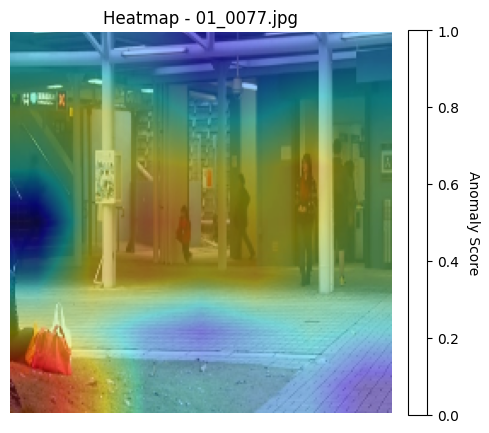

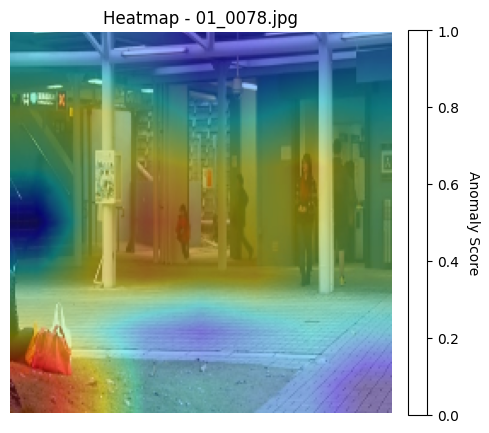

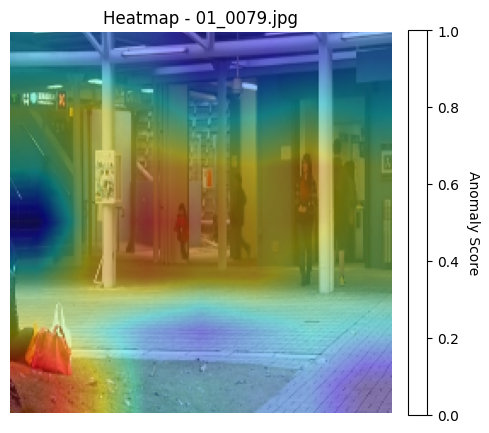

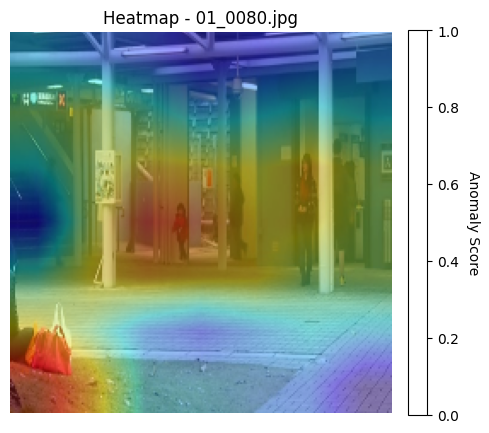

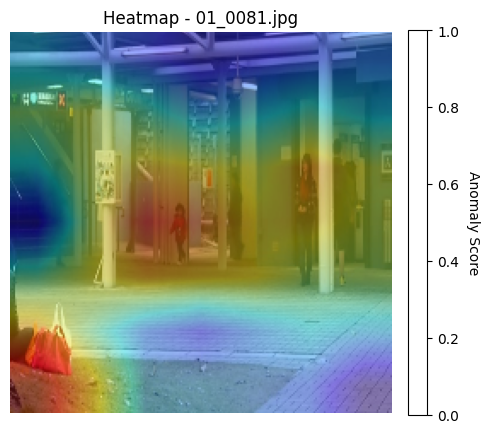

In [ ]:
import os
import numpy as np
import cv2
import torch
import timm
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt

# ⚙️ Path to abnormal images
anomaly_dir = "/content/frames_balanced/abnormal"
IMG_SIZE = 224

# 🌀 Preprocessing
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 🧠 Load model
model = timm.create_model('repvgg_a0', pretrained=True, num_classes=2)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 🔍 Grad-CAM++
class GradCAMPlusPlus:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor):
        self.model.zero_grad()
        output = self.model(input_tensor)
        class_idx = torch.argmax(output, dim=1).item()
        score = output[0, class_idx]
        score.backward()

        gradients = self.gradients
        activations = self.activations

        b, k, h, w = gradients.size()
        alpha_num = gradients.pow(2)
        alpha_denom = 2 * gradients.pow(2) + activations * gradients.pow(3).sum(-1).sum(-1).view(b, k, 1, 1)
        alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.ones_like(alpha_denom))
        alpha = alpha_num / alpha_denom

        weights = torch.relu(F.relu(gradients) * alpha).sum(-1).sum(-1).view(b, k, 1, 1)
        cam = (weights * activations).sum(1, keepdim=True)

        cam = F.relu(cam)
        cam = F.interpolate(cam, size=(IMG_SIZE, IMG_SIZE), mode='bilinear', align_corners=False)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        return cam.cpu().detach().numpy().squeeze()

# 🎯 Identify target convolutional layer
conv_layers = [m for m in model.modules() if isinstance(m, torch.nn.Conv2d)]
target_layer = conv_layers[-1]
gradcam = GradCAMPlusPlus(model, target_layer)

# 📂 Get list of image paths
image_paths = sorted([
    os.path.join(anomaly_dir, fname)
    for fname in os.listdir(anomaly_dir)
    if fname.lower().endswith(('.jpg', '.jpeg', '.png'))
])[:5]  # Only the first 5 images

# 🔥 Process and display heatmaps
for path in image_paths:
    img = cv2.imread(path)
    if img is None:
        continue
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = preprocess(img_rgb).unsqueeze(0).to(device)

    # Generate heatmap
    heatmap = gradcam.generate(img_tensor)

    # Convert to colored heatmap
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    # Resize original image
    img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))

    # Blend heatmap with original image
    alpha = 0.4
    blended = cv2.addWeighted(img_resized, 1 - alpha, heatmap_color, alpha, 0)

    # Display with matplotlib + colorbar
    plt.figure(figsize=(5, 5))
    plt.imshow(blended)
    plt.title(f"Heatmap - {os.path.basename(path)}")
    plt.axis('off')

    # Add colorbar from raw heatmap
    im = plt.imshow(heatmap, cmap='jet', alpha=0)
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.set_label("Anomaly Score", rotation=270, labelpad=15)

    plt.tight_layout()
    plt.show()


In [ ]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, GRU, SimpleRNN, Flatten
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# from sklearn.utils import shuffle
# import matplotlib.pyplot as plt
# import pandas as pd
# import gc
# from tensorflow.keras import backend as K
# import seaborn as sns
# import os

# # Force CPU usage to avoid cuDNN errors
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

# # --- Data loading and preprocessing ---
# def prepare_data(normal_path, anomaly_path):
#     X_normal = np.load(normal_path, allow_pickle=True)
#     print(f"X_normal shape before mean: {X_normal.shape}")
#     if X_normal.ndim >= 4:
#         X_normal = X_normal.mean(axis=(2, 3))
#         print(f"X_normal shape after mean(axis=(2,3)): {X_normal.shape}")
#     else:
#         print("X_normal has less than 4 dims, skipping mean over axis 2 and 3")

#     X_anomaly = np.load(anomaly_path, allow_pickle=True)
#     print(f"X_anomaly shape before mean: {X_anomaly.shape}")
#     if X_anomaly.ndim >= 4:
#         X_anomaly = X_anomaly.mean(axis=(2, 3))
#         print(f"X_anomaly shape after mean(axis=(2,3)): {X_anomaly.shape}")
#     else:
#         print("X_anomaly has less than 4 dims, skipping mean over axis 2 and 3")

#     X = np.concatenate([X_normal, X_anomaly])
#     y = np.concatenate([np.zeros(len(X_normal)), np.ones(len(X_anomaly))])

#     # Convert to float32 for TensorFlow compatibility
#     X = X.astype(np.float32)

#     # Check for NaN or Inf values
#     print("NaN in X:", np.any(np.isnan(X)))
#     print("Inf in X:", np.any(np.isinf(X)))
#     X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)  # Clean data

#     X, y = shuffle(X, y, random_state=42)
#     return X, y

# def create_sequences(X, y, seq_len=5):
#     X_seq, y_seq = [], []
#     for i in range(len(X) - seq_len + 1):
#         X_seq.append(X[i:i + seq_len])
#         y_seq.append(y[i + seq_len - 1])
#     return np.array(X_seq), np.array(y_seq)

# # --- Model builders ---
# def build_lstm_model(input_shape):
#     inputs = Input(shape=input_shape)
#     x = LSTM(64, activation='tanh', recurrent_activation='sigmoid', use_bias=True, unroll=True)(inputs)  # unroll=True to avoid cuDNN
#     x = Dropout(0.3)(x)
#     x = Dense(32, activation='relu')(x)
#     x = Dropout(0.3)(x)
#     outputs = Dense(1, activation='sigmoid')(x)
#     model = Model(inputs, outputs)
#     model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# def build_gru_model(input_shape):
#     inputs = Input(shape=input_shape)
#     x = GRU(64)(inputs)
#     x = Dropout(0.3)(x)
#     x = Dense(32, activation='relu')(x)
#     x = Dropout(0.3)(x)
#     outputs = Dense(1, activation='sigmoid')(x)
#     model = Model(inputs, outputs)
#     model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# def build_lstm_gru_model(input_shape):
#     inputs = Input(shape=input_shape)
#     x = LSTM(64, return_sequences=True, activation='tanh', recurrent_activation='sigmoid', use_bias=True, unroll=True)(inputs)
#     x = Dropout(0.3)(x)
#     x = GRU(64)(x)
#     x = Dropout(0.3)(x)
#     x = Dense(32, activation='relu')(x)
#     x = Dropout(0.3)(x)
#     outputs = Dense(1, activation='sigmoid')(x)
#     model = Model(inputs, outputs)
#     model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# def build_rnn_model(input_shape):
#     inputs = Input(shape=input_shape)
#     x = SimpleRNN(64)(inputs)
#     x = Dropout(0.3)(x)
#     x = Dense(32, activation='relu')(x)
#     x = Dropout(0.3)(x)
#     outputs = Dense(1, activation='sigmoid')(x)
#     model = Model(inputs, outputs)
#     model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# def build_dense_model(input_shape):
#     inputs = Input(shape=input_shape)
#     x = Flatten()(inputs)
#     x = Dense(64, activation='relu')(x)
#     x = Dropout(0.3)(x)
#     x = Dense(32, activation='relu')(x)
#     x = Dropout(0.3)(x)
#     outputs = Dense(1, activation='sigmoid')(x)
#     model = Model(inputs, outputs)
#     model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# # --- Train and evaluate using k-fold ---
# def train_and_evaluate_kfold(model_fn, X, y, model_name, n_splits=5):
#     skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
#     metrics_per_fold = {
#         'accuracy': [],
#         'precision': [],
#         'recall': [],
#         'f1': [],
#         'val_loss': [],
#         'val_accuracy': []
#     }
#     val_loss_histories = []
#     val_acc_histories = []

#     fold_num = 1
#     for train_idx, val_idx in skf.split(X, y):
#         print(f"\n➡️ Fold {fold_num}/{n_splits} - Model: {model_name}")
#         X_train, X_val = X[train_idx], X[val_idx]
#         y_train, y_val = y[train_idx], y[val_idx]

#         model = model_fn(X_train.shape[1:])
#         es = EarlyStopping(patience=5, restore_best_weights=True, verbose=1)

#         history = model.fit(
#             X_train, y_train,
#             validation_data=(X_val, y_val),
#             epochs=50,
#             batch_size=32,
#             callbacks=[es],
#             verbose=1
#         )

#         y_pred = (model.predict(X_val) > 0.5).astype(int)

#         acc = accuracy_score(y_val, y_pred)
#         prec = precision_score(y_val, y_pred, zero_division=0)
#         rec = recall_score(y_val, y_pred, zero_division=0)
#         f1 = f1_score(y_val, y_pred, zero_division=0)

#         print(f"Fold {fold_num} - Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}")

#         metrics_per_fold['accuracy'].append(acc)
#         metrics_per_fold['precision'].append(prec)
#         metrics_per_fold['recall'].append(rec)
#         metrics_per_fold['f1'].append(f1)
#         metrics_per_fold['val_loss'].append(history.history['val_loss'][-1])
#         metrics_per_fold['val_accuracy'].append(history.history['val_accuracy'][-1])

#         val_loss_histories.append(history.history['val_loss'])
#         val_acc_histories.append(history.history['val_accuracy'])

#         K.clear_session()  # Clear memory
#         del model
#         gc.collect()

#         fold_num += 1

#     # Average metrics
#     avg_metrics = {k: np.mean(v) for k, v in metrics_per_fold.items()}
#     print(f"\n➡️ {model_name} - Mean Metrics over {n_splits} folds:")
#     print(f"Accuracy: {avg_metrics['accuracy']:.4f}, Precision: {avg_metrics['precision']:.4f}, Recall: {avg_metrics['recall']:.4f}, F1: {avg_metrics['f1']:.4f}")

#     # Average val_loss and val_accuracy curves (pad shorter histories with last value)
#     max_epochs = max(len(h) for h in val_loss_histories)

#     def pad_history(histories, max_len):
#         padded = []
#         for h in histories:
#             if len(h) < max_len:
#                 h = h + [h[-1]] * (max_len - len(h))
#             padded.append(h)
#         return np.array(padded)

#     avg_val_loss = np.mean(pad_history(val_loss_histories, max_epochs), axis=0)
#     avg_val_acc = np.mean(pad_history(val_acc_histories, max_epochs), axis=0)

#     return avg_metrics, avg_val_loss, avg_val_acc

# def main():
#     feature_model_names = [
#         'convnext_tiny',
#         'repvgg_a0',
#         'mobileone_s0',
#         'poolformer_s12',
#         'maxvit_tiny_tf_224',
#         'coatnet_0_rw_224'
#     ]

#     model_builders = {
#         "LSTM": build_lstm_model,
#         "GRU": build_gru_model,
#         "LSTM_GRU": build_lstm_gru_model,
#         "SimpleRNN": build_rnn_model,
#         "Dense": build_dense_model
#     }

#     seq_len = 10
#     save_dir = '/content/drive/MyDrive/AVA'  # Adjust path as needed
#     all_results = []
#     curve_data = {}

#     for feature_model_name in feature_model_names:
#         print(f"\n\n📁 Loading features for model: {feature_model_name}")
#         normal_path = f"{save_dir}/normal_features_{feature_model_name}.npy"
#         anomaly_path = f"{save_dir}/anomaly_features_{feature_model_name}.npy"

#         X, y = prepare_data(normal_path, anomaly_path)
#         X_seq, y_seq = create_sequences(X, y, seq_len=seq_len)

#         print(f"X_seq shape: {X_seq.shape}, y_seq shape: {y_seq.shape}")

#         for model_name, builder in model_builders.items():
#             full_model_name = f"{feature_model_name}_{model_name}"
#             metrics, avg_val_loss, avg_val_acc = train_and_evaluate_kfold(builder, X_seq, y_seq, full_model_name, n_splits=5)
#             metrics.update({"Feature_Model": feature_model_name, "Architecture": model_name})
#             all_results.append(metrics)

#             curve_data[full_model_name] = {
#                 'val_loss': avg_val_loss,
#                 'val_accuracy': avg_val_acc
#             }

#     df = pd.DataFrame(all_results)
#     print("\n\n📊 Overall Model Comparison:\n")
#     print(df)

#     metrics_to_plot = ["accuracy", "precision", "recall", "f1"]
#     plt.figure(figsize=(16, 6))
#     for i, metric in enumerate(metrics_to_plot):
#         plt.subplot(1, len(metrics_to_plot), i + 1)
#         sns.barplot(x="Feature_Model", y=metric, hue="Architecture", data=df)
#         plt.title(metric.capitalize())
#         plt.ylim(0, 1)
#         plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()

#     plt.figure(figsize=(16, 6))
#     plt.subplot(1, 2, 1)
#     for name, curves in curve_data.items():
#         plt.plot(curves['val_accuracy'], label=name)
#     plt.title('Validation Accuracy (averaged over folds)')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.ylim(0, 1)
#     plt.legend(fontsize=8, loc='lower right')

#     plt.subplot(1, 2, 2)
#     for name, curves in curve_data.items():
#         plt.plot(curves['val_loss'], label=name)
#     plt.title('Validation Loss (averaged over folds)')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend(fontsize=8, loc='upper right')

#     plt.tight_layout()
#     plt.show()

# if __name__ == "__main__":
#     main()

In [ ]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, GRU, SimpleRNN, Flatten
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import (
#     accuracy_score, precision_score, recall_score, f1_score,
#     roc_auc_score, confusion_matrix, classification_report,
#     roc_curve, precision_recall_curve, auc
# )
# from sklearn.utils import shuffle
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# import os

# os.environ["CUDA_VISIBLE_DEVICES"] = ""

# # --- Data loading and preprocessing ---
# def prepare_data(normal_path, anomaly_path):
#     X_normal = np.load(normal_path, allow_pickle=True)
#     if X_normal.ndim >= 4:
#         X_normal = X_normal.mean(axis=(2, 3))
#     X_anomaly = np.load(anomaly_path, allow_pickle=True)
#     if X_anomaly.ndim >= 4:
#         X_anomaly = X_anomaly.mean(axis=(2, 3))
#     X = np.concatenate([X_normal, X_anomaly])
#     y = np.concatenate([np.zeros(len(X_normal)), np.ones(len(X_anomaly))])
#     X = X.astype(np.float32)
#     X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
#     X, y = shuffle(X, y, random_state=42)
#     return X, y

# def create_sequences(X, y, seq_len=5):
#     X_seq, y_seq = [], []
#     for i in range(len(X) - seq_len + 1):
#         X_seq.append(X[i:i + seq_len])
#         y_seq.append(y[i + seq_len - 1])
#     return np.array(X_seq), np.array(y_seq)

# # --- Model builders with 32 and 16 units ---
# def build_lstm_model(input_shape):
#     inputs = Input(shape=input_shape)
#     x = LSTM(32, activation='tanh', recurrent_activation='sigmoid', unroll=True)(inputs)
#     x = Dropout(0.3)(x)
#     x = Dense(16, activation='relu')(x)
#     x = Dropout(0.3)(x)
#     outputs = Dense(1, activation='sigmoid')(x)
#     model = Model(inputs, outputs)
#     model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# def build_gru_model(input_shape):
#     inputs = Input(shape=input_shape)
#     x = GRU(32)(inputs)
#     x = Dropout(0.3)(x)
#     x = Dense(16, activation='relu')(x)
#     x = Dropout(0.3)(x)
#     outputs = Dense(1, activation='sigmoid')(x)
#     model = Model(inputs, outputs)
#     model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# def build_lstm_gru_model(input_shape):
#     inputs = Input(shape=input_shape)
#     x = LSTM(32, return_sequences=True, unroll=True)(inputs)
#     x = Dropout(0.3)(x)
#     x = GRU(32)(x)
#     x = Dropout(0.3)(x)
#     x = Dense(16, activation='relu')(x)
#     x = Dropout(0.3)(x)
#     outputs = Dense(1, activation='sigmoid')(x)
#     model = Model(inputs, outputs)
#     model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# def build_simple_rnn_model(input_shape):
#     inputs = Input(shape=input_shape)
#     x = SimpleRNN(32)(inputs)
#     x = Dropout(0.3)(x)
#     x = Dense(16, activation='relu')(x)
#     x = Dropout(0.3)(x)
#     outputs = Dense(1, activation='sigmoid')(x)
#     model = Model(inputs, outputs)
#     model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# def build_dense_model(input_shape):
#     inputs = Input(shape=input_shape)
#     x = Flatten()(inputs)
#     x = Dense(32, activation='relu')(x)
#     x = Dropout(0.3)(x)
#     x = Dense(16, activation='relu')(x)
#     x = Dropout(0.3)(x)
#     outputs = Dense(1, activation='sigmoid')(x)
#     model = Model(inputs, outputs)
#     model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# # --- Main execution ---
# def main():
#     feature_model_name = 'convnext_tiny'  # adjust if needed
#     seq_len = 10
#     save_dir = '/content/drive/MyDrive/AVA'  # adjust to your paths
#     normal_path = f"{save_dir}/normal_features_{feature_model_name}.npy"
#     anomaly_path = f"{save_dir}/anomaly_features_{feature_model_name}.npy"

#     X, y = prepare_data(normal_path, anomaly_path)
#     X_seq, y_seq = create_sequences(X, y, seq_len=seq_len)

#     model_builders = {
#         "LSTM": build_lstm_model,
#         "GRU": build_gru_model,
#         "LSTM_GRU": build_lstm_gru_model,
#         "SimpleRNN": build_simple_rnn_model,
#         "Dense": build_dense_model
#     }

#     num_runs = 5
#     all_results = []

#     for model_name, builder in model_builders.items():
#         print(f"\n==== Training model: {model_name} ====")

#         metrics_list = {
#             "accuracy": [],
#             "precision": [],
#             "recall": [],
#             "f1": [],
#             "auc": []
#         }

#         for run in range(num_runs):
#             print(f" Run {run+1}/{num_runs}")

#             X_train, X_test, y_train, y_test = train_test_split(
#                 X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=run
#             )

#             model = builder(X_train.shape[1:])
#             es = EarlyStopping(patience=5, restore_best_weights=True, verbose=0)
#             history = model.fit(
#                 X_train, y_train,
#                 validation_data=(X_test, y_test),
#                 epochs=50,
#                 batch_size=32,
#                 callbacks=[es],
#                 verbose=0
#             )

#             y_prob = model.predict(X_test).ravel()
#             y_pred = (y_prob > 0.5).astype(int)

#             acc = accuracy_score(y_test, y_pred)
#             prec = precision_score(y_test, y_pred, zero_division=0)
#             rec = recall_score(y_test, y_pred, zero_division=0)
#             f1 = f1_score(y_test, y_pred, zero_division=0)
#             auc_score = roc_auc_score(y_test, y_prob)

#             # Store metrics
#             metrics_list["accuracy"].append(acc)
#             metrics_list["precision"].append(prec)
#             metrics_list["recall"].append(rec)
#             metrics_list["f1"].append(f1)
#             metrics_list["auc"].append(auc_score)

#             all_results.append({
#                 "Model": model_name,
#                 "Run": run + 1,
#                 "Accuracy": acc,
#                 "Precision": prec,
#                 "Recall": rec,
#                 "F1": f1,
#                 "AUC": auc_score
#             })

#             # For last run, print detailed info and plots
#             if run == num_runs - 1:
#                 print(f"\n--- Detailed results for {model_name} (run {run+1}) ---")
#                 print(f"Accuracy: {acc:.4f}")
#                 print(f"Precision: {prec:.4f}")
#                 print(f"Recall: {rec:.4f}")
#                 print(f"F1-score: {f1:.4f}")
#                 print(f"AUC: {auc_score:.4f}")

#                 print("\nConfusion Matrix:")
#                 cm = confusion_matrix(y_test, y_pred)
#                 print(cm)

#                 print("\nClassification Report:")
#                 print(classification_report(y_test, y_pred, digits=4))

#                 # ROC Curve
#                 fpr, tpr, _ = roc_curve(y_test, y_prob)
#                 roc_auc = auc(fpr, tpr)
#                 plt.figure(figsize=(6,5))
#                 plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
#                 plt.plot([0,1], [0,1], 'k--')
#                 plt.title(f'{model_name} ROC Curve')
#                 plt.xlabel('False Positive Rate')
#                 plt.ylabel('True Positive Rate')
#                 plt.legend(loc='lower right')
#                 plt.grid(True)
#                 plt.show()

#                 # Precision-Recall Curve
#                 precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
#                 pr_auc = auc(recall_vals, precision_vals)
#                 plt.figure(figsize=(6,5))
#                 plt.plot(recall_vals, precision_vals, label=f'PR curve (AUC = {pr_auc:.3f})')
#                 plt.title(f'{model_name} Precision-Recall Curve')
#                 plt.xlabel('Recall')
#                 plt.ylabel('Precision')
#                 plt.legend(loc='upper right')
#                 plt.grid(True)
#                 plt.show()

#                 # Training plots
#                 plt.figure(figsize=(12,5))
#                 plt.subplot(1,2,1)
#                 plt.plot(history.history['accuracy'], label='Train Accuracy')
#                 plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
#                 plt.title(f'{model_name} Accuracy')
#                 plt.xlabel('Epoch')
#                 plt.ylabel('Accuracy')
#                 plt.legend()
#                 plt.grid(True)

#                 plt.subplot(1,2,2)
#                 plt.plot(history.history['loss'], label='Train Loss')
#                 plt.plot(history.history['val_loss'], label='Validation Loss')
#                 plt.title(f'{model_name} Loss')
#                 plt.xlabel('Epoch')
#                 plt.ylabel('Loss')
#                 plt.legend()
#                 plt.grid(True)

#                 plt.tight_layout()
#                 plt.show()

#         # Print mean and std for all runs
#         print(f"\n==== Summary for {model_name} (over {num_runs} runs) ====")
#         for metric in metrics_list:
#             mean_val = np.mean(metrics_list[metric])
#             std_val = np.std(metrics_list[metric])
#             print(f"{metric.capitalize()}: {mean_val:.4f} ± {std_val:.4f}")

#     # Save all results to CSV
#     df = pd.DataFrame(all_results)
#     csv_save_path = os.path.join(save_dir, f"results_all_models_{feature_model_name}.csv")
#     df.to_csv(csv_save_path, index=False)
#     print(f"\nAll run results saved to: {csv_save_path}")

# if __name__ == "__main__":
#     main()



==== Training model: LSTM ====
 Run 1/5
Epoch 1/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6749 - loss: 0.5634 - val_accuracy: 0.9039 - val_loss: 0.2902
Epoch 2/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8815 - loss: 0.3198 - val_accuracy: 0.9126 - val_loss: 0.2306
Epoch 3/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9074 - loss: 0.2544 - val_accuracy: 0.9294 - val_loss: 0.1881
Epoch 4/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9215 - loss: 0.2164 - val_accuracy: 0.9337 - val_loss: 0.1693
Epoch 5/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9320 - loss: 0.1945 - val_accuracy: 0.9425 - val_loss: 0.1499
Epoch 6/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9361 - loss: 0.1813 - val_accuracy: 0.9462 - val_loss: 0.1392
Epoch 7/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9404 - loss: 0.1676 - val_accuracy: 0.9481 - val_loss: 0.1365
Epoch 8/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy:

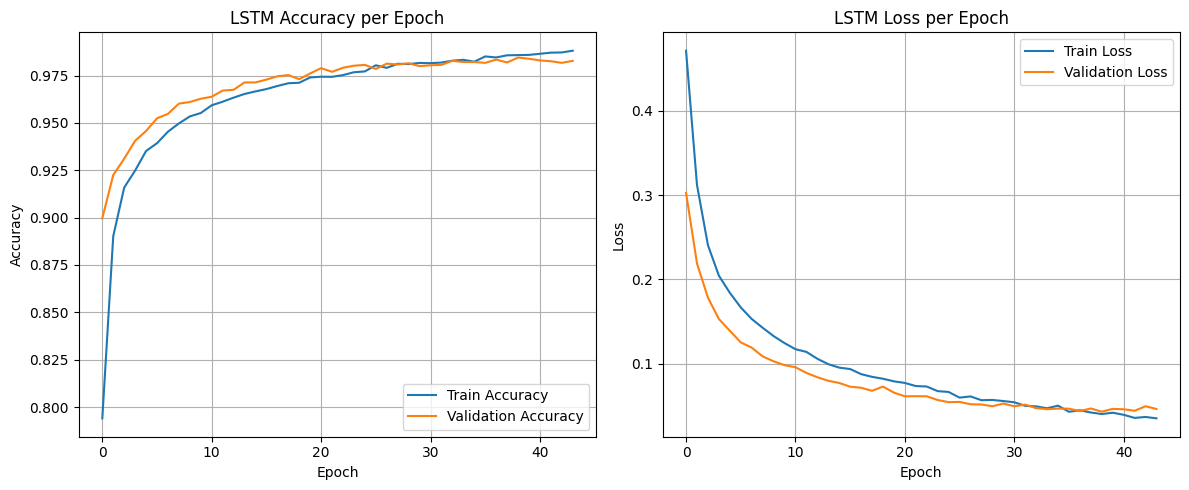


==== Summary for LSTM (over 5 runs) ====
Accuracy: 0.9855 ± 0.0028
Precision: 0.9870 ± 0.0022
Recall: 0.9839 ± 0.0047
F1: 0.9855 ± 0.0028
Auc: 0.9989 ± 0.0004


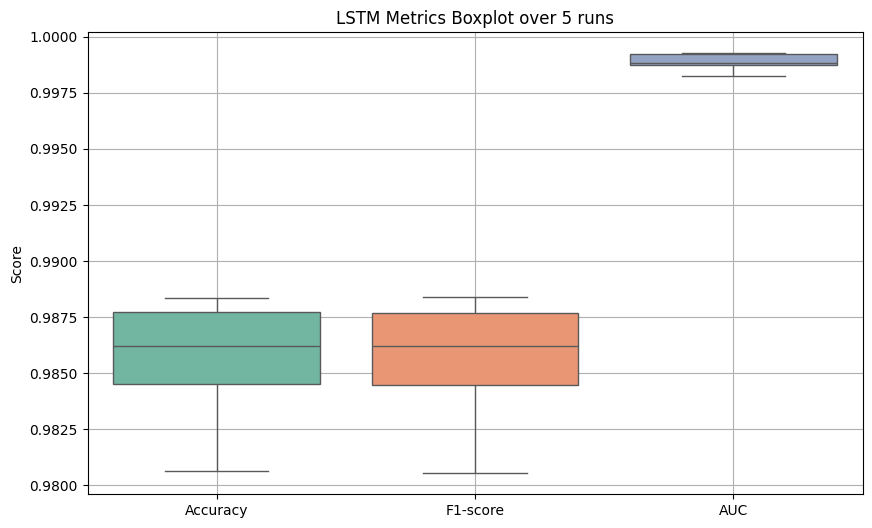


==== Training model: GRU ====
 Run 1/5
Epoch 1/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6945 - loss: 0.5617 - val_accuracy: 0.9121 - val_loss: 0.2502
Epoch 2/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8871 - loss: 0.2949 - val_accuracy: 0.9214 - val_loss: 0.2054
Epoch 3/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9109 - loss: 0.2370 - val_accuracy: 0.9300 - val_loss: 0.1804
Epoch 4/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9250 - loss: 0.1991 - val_accuracy: 0.9352 - val_loss: 0.1602
Epoch 5/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9277 - loss: 0.1937 - val_accuracy: 0.9369 - val_loss: 0.1500
Epoch 6/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9328 - loss: 0.1720 - val_accuracy: 0.9436 - val_loss: 0.1396
Epoch 7/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9391 - loss: 0.1592 - val_accuracy: 0.9459 - val_loss: 0.1319
Epoch 8/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 

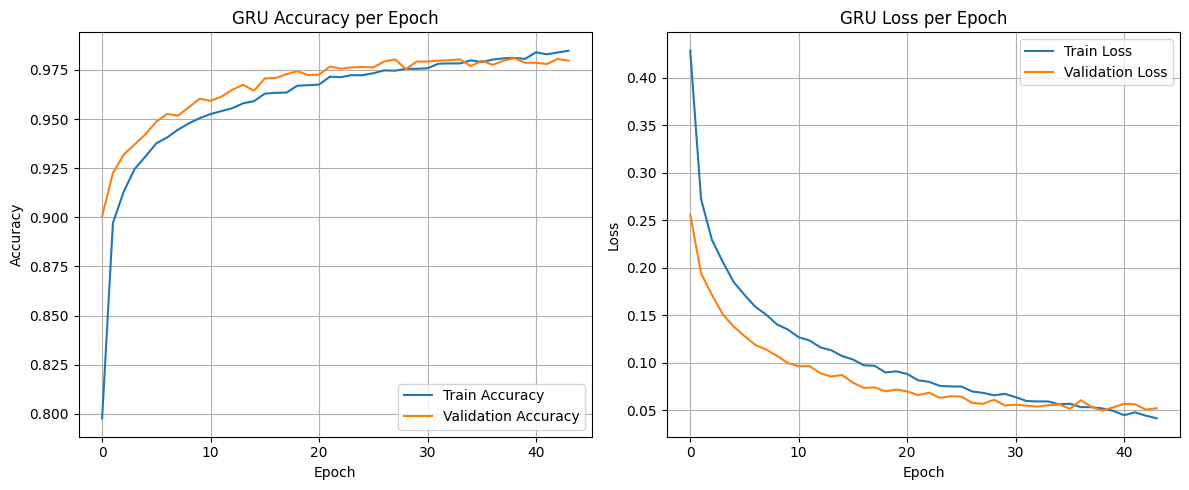


==== Summary for GRU (over 5 runs) ====
Accuracy: 0.9791 ± 0.0044
Precision: 0.9835 ± 0.0040
Recall: 0.9745 ± 0.0052
F1: 0.9790 ± 0.0045
Auc: 0.9979 ± 0.0005


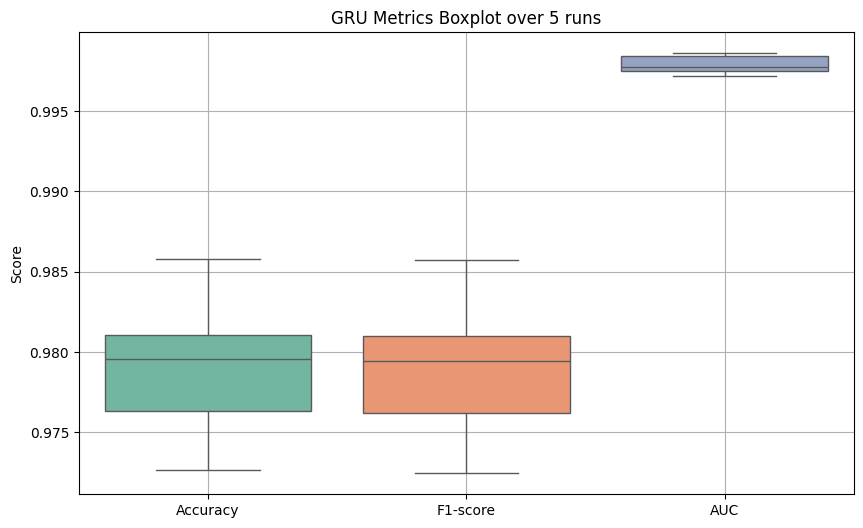


==== Training model: LSTM_GRU ====
 Run 1/5
Epoch 1/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.6342 - loss: 0.6308 - val_accuracy: 0.9009 - val_loss: 0.2999
Epoch 2/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8859 - loss: 0.3248 - val_accuracy: 0.9227 - val_loss: 0.2061
Epoch 3/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9151 - loss: 0.2399 - val_accuracy: 0.9380 - val_loss: 0.1617
Epoch 4/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9329 - loss: 0.1977 - val_accuracy: 0.9444 - val_loss: 0.1455
Epoch 5/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9418 - loss: 0.1694 - val_accuracy: 0.9483 - val_loss: 0.1287
Epoch 6/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9452 - loss: 0.1589 - val_accuracy: 0.9546 - val_loss: 0.1180
Epoch 7/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9508 - loss: 0.1399 - val_accuracy: 0.9565 - val_loss: 0.1079
Epoch 8/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/ste

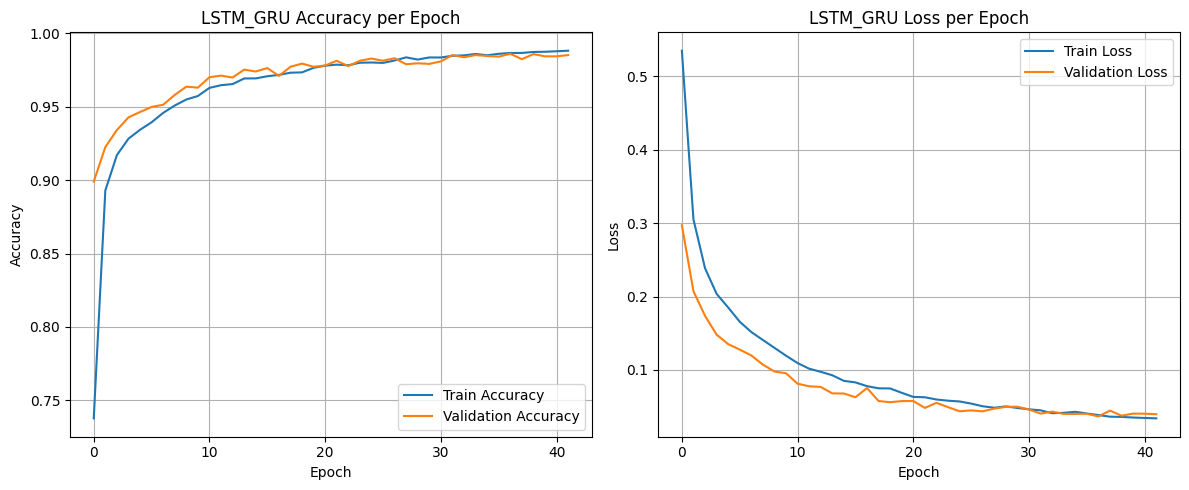


==== Summary for LSTM_GRU (over 5 runs) ====
Accuracy: 0.9848 ± 0.0030
Precision: 0.9870 ± 0.0015
Recall: 0.9826 ± 0.0053
F1: 0.9848 ± 0.0030
Auc: 0.9988 ± 0.0005


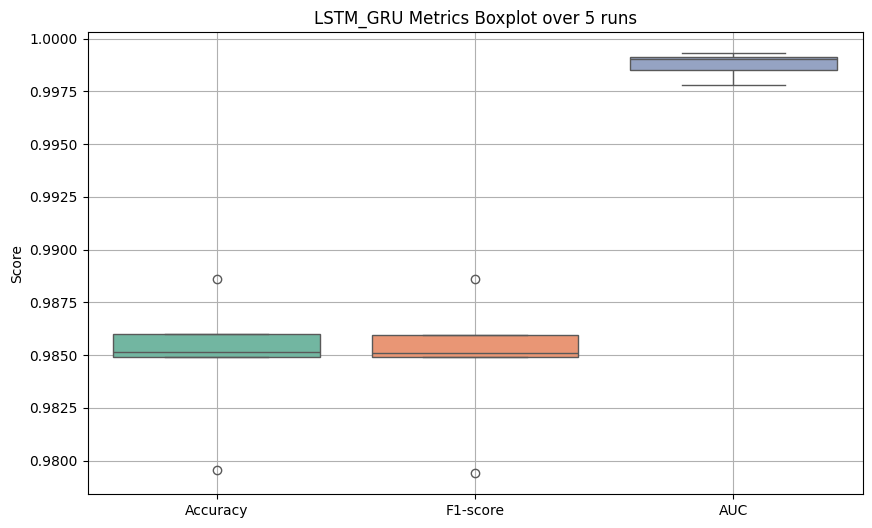


==== Training model: SimpleRNN ====
 Run 1/5
Epoch 1/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7277 - loss: 0.5212 - val_accuracy: 0.8977 - val_loss: 0.2611
Epoch 2/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8721 - loss: 0.3081 - val_accuracy: 0.9164 - val_loss: 0.2092
Epoch 3/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9029 - loss: 0.2561 - val_accuracy: 0.9250 - val_loss: 0.1865
Epoch 4/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9133 - loss: 0.2227 - val_accuracy: 0.9283 - val_loss: 0.1745
Epoch 5/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9194 - loss: 0.2035 - val_accuracy: 0.9373 - val_loss: 0.1598
Epoch 6/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9310 - loss: 0.1812 - val_accuracy: 0.9371 - val_loss: 0.1486
Epoch 7/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9356 - loss: 0.1715 - val_accuracy: 0.9403 - val_loss: 0.1395
Epoch 8/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accu

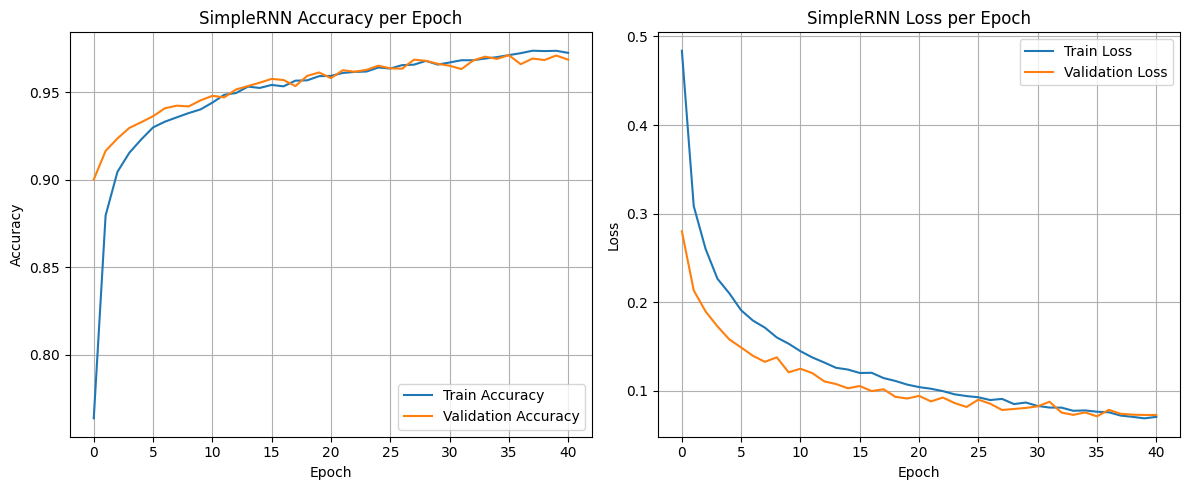


==== Summary for SimpleRNN (over 5 runs) ====
Accuracy: 0.9756 ± 0.0038
Precision: 0.9848 ± 0.0030
Recall: 0.9660 ± 0.0069
F1: 0.9753 ± 0.0039
Auc: 0.9969 ± 0.0007


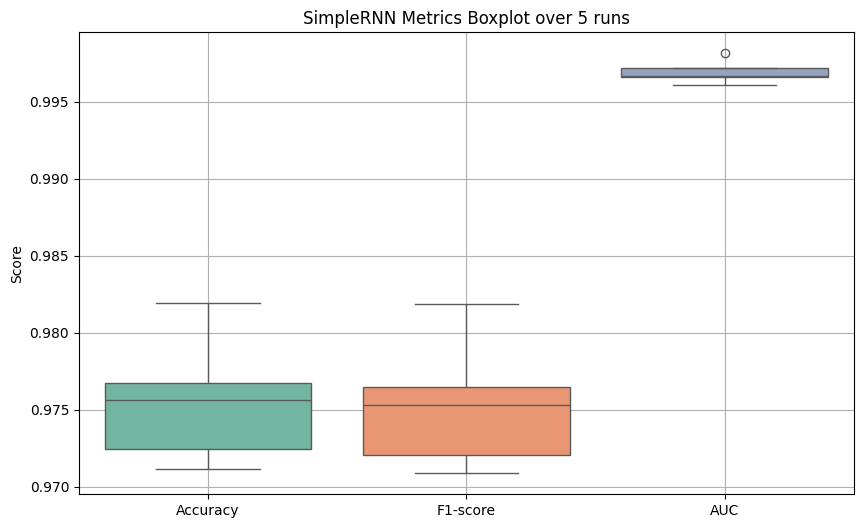


==== Training model: Dense ====
 Run 1/5
Epoch 1/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5977 - loss: 0.6549 - val_accuracy: 0.8574 - val_loss: 0.4149
Epoch 2/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7853 - loss: 0.4431 - val_accuracy: 0.8970 - val_loss: 0.3153
Epoch 3/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8474 - loss: 0.3641 - val_accuracy: 0.9007 - val_loss: 0.2623
Epoch 4/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8669 - loss: 0.3315 - val_accuracy: 0.9093 - val_loss: 0.2394
Epoch 5/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8823 - loss: 0.2994 - val_accuracy: 0.9065 - val_loss: 0.2262
Epoch 6/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8877 - loss: 0.2806 - val_accuracy: 0.9143 - val_loss: 0.2109
Epoch 7/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9012 - loss: 0.2601 - val_accuracy: 0.9085 - val_loss: 0.2223
Epoch 8/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy

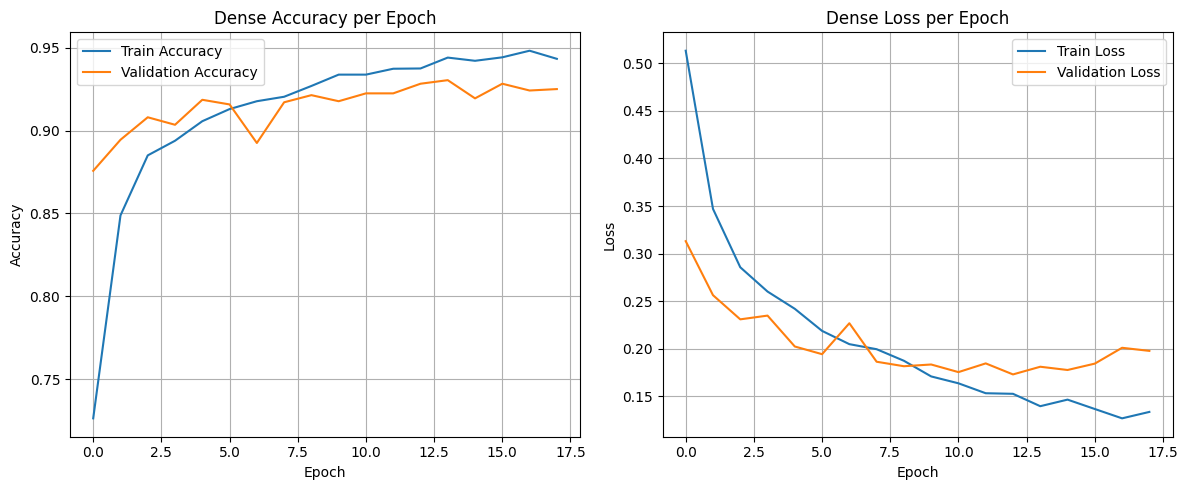


==== Summary for Dense (over 5 runs) ====
Accuracy: 0.9320 ± 0.0051
Precision: 0.9461 ± 0.0069
Recall: 0.9162 ± 0.0141
F1: 0.9308 ± 0.0057
Auc: 0.9831 ± 0.0021


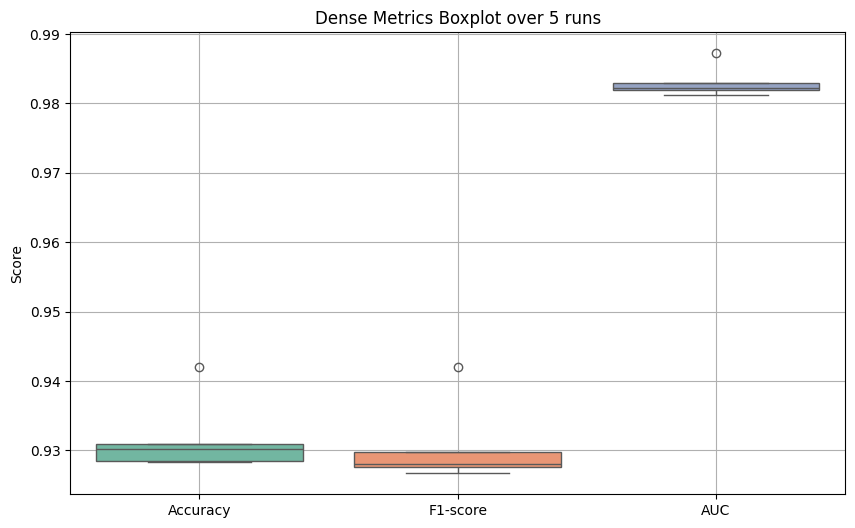


All run results saved to: /content/drive/MyDrive/AVA/results_all_models_convnext_tiny.csv


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, GRU, SimpleRNN, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, auc
)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import gc
from tensorflow.keras import backend as K

os.environ["CUDA_VISIBLE_DEVICES"] = ""

# --- Data loading and preprocessing ---
def prepare_data(normal_path, anomaly_path):
    X_normal = np.load(normal_path, allow_pickle=True)
    if X_normal.ndim >= 4:
        X_normal = X_normal.mean(axis=(2, 3))
    X_anomaly = np.load(anomaly_path, allow_pickle=True)
    if X_anomaly.ndim >= 4:
        X_anomaly = X_anomaly.mean(axis=(2, 3))
    X = np.concatenate([X_normal, X_anomaly])
    y = np.concatenate([np.zeros(len(X_normal)), np.ones(len(X_anomaly))])
    X = X.astype(np.float32)
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    X, y = shuffle(X, y, random_state=42)
    return X, y

def create_sequences(X, y, seq_len=5):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len + 1):
        X_seq.append(X[i:i + seq_len])
        y_seq.append(y[i + seq_len - 1])
    return np.array(X_seq), np.array(y_seq)

# --- Model builders with 32 and 16 units ---
def build_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(32, activation='tanh', recurrent_activation='sigmoid', unroll=True)(inputs)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_gru_model(input_shape):
    inputs = Input(shape=input_shape)
    x = GRU(32)(inputs)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_lstm_gru_model(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(32, return_sequences=True, unroll=True)(inputs)
    x = Dropout(0.3)(x)
    x = GRU(32)(x)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_simple_rnn_model(input_shape):
    inputs = Input(shape=input_shape)
    x = SimpleRNN(32)(inputs)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_dense_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Flatten()(inputs)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# --- Main execution ---
def main():
    feature_model_name = 'convnext_tiny'  # Change if needed
    seq_len = 10
    save_dir = '/content/drive/MyDrive/AVA'  # Change to your data path
    normal_path = f"{save_dir}/normal_features_{feature_model_name}.npy"
    anomaly_path = f"{save_dir}/anomaly_features_{feature_model_name}.npy"

    X, y = prepare_data(normal_path, anomaly_path)
    X_seq, y_seq = create_sequences(X, y, seq_len=seq_len)

    model_builders = {
        "LSTM": build_lstm_model,
        "GRU": build_gru_model,
        "LSTM_GRU": build_lstm_gru_model,
        "SimpleRNN": build_simple_rnn_model,
        "Dense": build_dense_model
    }

    num_runs = 5
    all_results = []

    for model_name, builder in model_builders.items():
        print(f"\n==== Training model: {model_name} ====")

        metrics_list = {
            "accuracy": [],
            "precision": [],
            "recall": [],
            "f1": [],
            "auc": []
        }

        histories = []

        for run in range(num_runs):
            print(f" Run {run+1}/{num_runs}")

            X_train, X_test, y_train, y_test = train_test_split(
                X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=run
            )

            model = builder(X_train.shape[1:])
            es = EarlyStopping(patience=5, restore_best_weights=True, verbose=0)
            history = model.fit(
                X_train, y_train,
                validation_data=(X_test, y_test),
                epochs=50,
                batch_size=32,
                callbacks=[es],
                verbose=1
            )
            histories.append(history)

            y_prob = model.predict(X_test).ravel()
            y_pred = (y_prob > 0.5).astype(int)

            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, zero_division=0)
            rec = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            auc_score = roc_auc_score(y_test, y_prob)

            # Store metrics
            metrics_list["accuracy"].append(acc)
            metrics_list["precision"].append(prec)
            metrics_list["recall"].append(rec)
            metrics_list["f1"].append(f1)
            metrics_list["auc"].append(auc_score)

            all_results.append({
                "Model": model_name,
                "Run": run + 1,
                "Accuracy": acc,
                "Precision": prec,
                "Recall": rec,
                "F1": f1,
                "AUC": auc_score
            })

            # Clear to save memory
            K.clear_session()
            del model
            gc.collect()

        # Plot training curves for last run
        last_history = histories[-1]
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(last_history.history['accuracy'], label='Train Accuracy')
        plt.plot(last_history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'{model_name} Accuracy per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.subplot(1,2,2)
        plt.plot(last_history.history['loss'], label='Train Loss')
        plt.plot(last_history.history['val_loss'], label='Validation Loss')
        plt.title(f'{model_name} Loss per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Print mean ± std summary for all runs
        print(f"\n==== Summary for {model_name} (over {num_runs} runs) ====")
        for metric in metrics_list:
            mean_val = np.mean(metrics_list[metric])
            std_val = np.std(metrics_list[metric])
            print(f"{metric.capitalize()}: {mean_val:.4f} ± {std_val:.4f}")

        # Plot boxplots of the 5 runs for metrics
        plt.figure(figsize=(10,6))
        sns.boxplot(data=[metrics_list["accuracy"], metrics_list["f1"], metrics_list["auc"]],
                    palette="Set2")
        plt.xticks([0,1,2], ['Accuracy', 'F1-score', 'AUC'])
        plt.title(f'{model_name} Metrics Boxplot over {num_runs} runs')
        plt.ylabel('Score')
        plt.grid(True)
        plt.show()

    # Save all results to CSV
    df = pd.DataFrame(all_results)
    csv_save_path = os.path.join(save_dir, f"results_all_models_{feature_model_name}.csv")
    df.to_csv(csv_save_path, index=False)
    print(f"\nAll run results saved to: {csv_save_path}")

if __name__ == "__main__":
    main()



==== Training model: LSTM ====
 Run 1/5
Epoch 1/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7465 - loss: 0.5055 - val_accuracy: 0.9082 - val_loss: 0.2393
Epoch 2/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9100 - loss: 0.2565 - val_accuracy: 0.9227 - val_loss: 0.1886
Epoch 3/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9221 - loss: 0.2126 - val_accuracy: 0.9343 - val_loss: 0.1632
Epoch 4/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9344 - loss: 0.1780 - val_accuracy: 0.9390 - val_loss: 0.1499
Epoch 5/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9391 - loss: 0.1623 - val_accuracy: 0.9462 - val_loss: 0.1312
Epoch 6/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9486 - loss: 0.1428 - val_accuracy: 0.9464 - val_loss: 0.1347
Epoch 7/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9480 - loss: 0.1390 - val_accuracy: 0.9494 - val_loss: 0.1276
Epoch 8/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy:

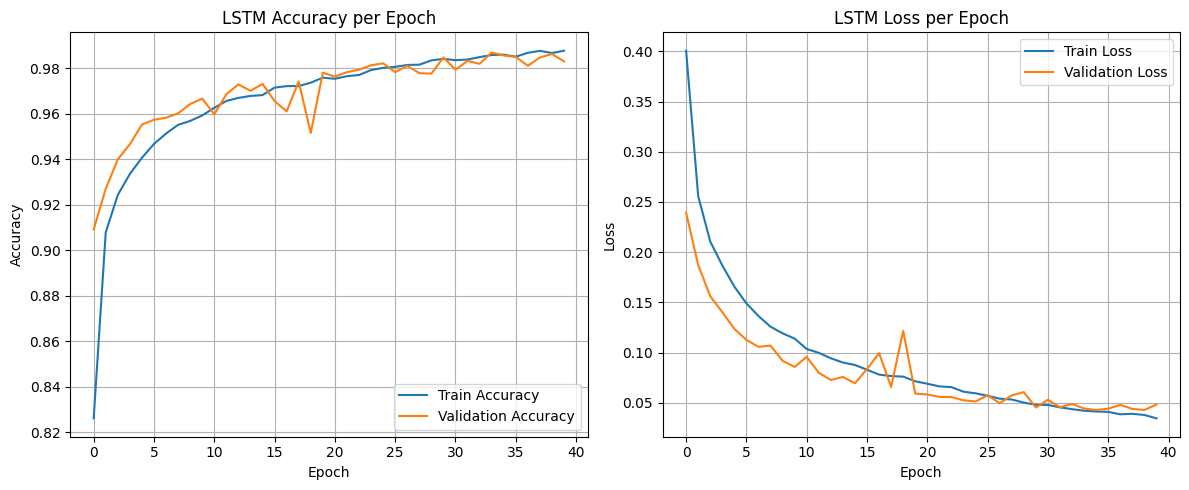


==== Summary for LSTM (over 5 runs) ====
Accuracy: 0.9824 ± 0.0029
Precision: 0.9837 ± 0.0041
Recall: 0.9810 ± 0.0030
F1: 0.9824 ± 0.0029
Auc: 0.9984 ± 0.0006


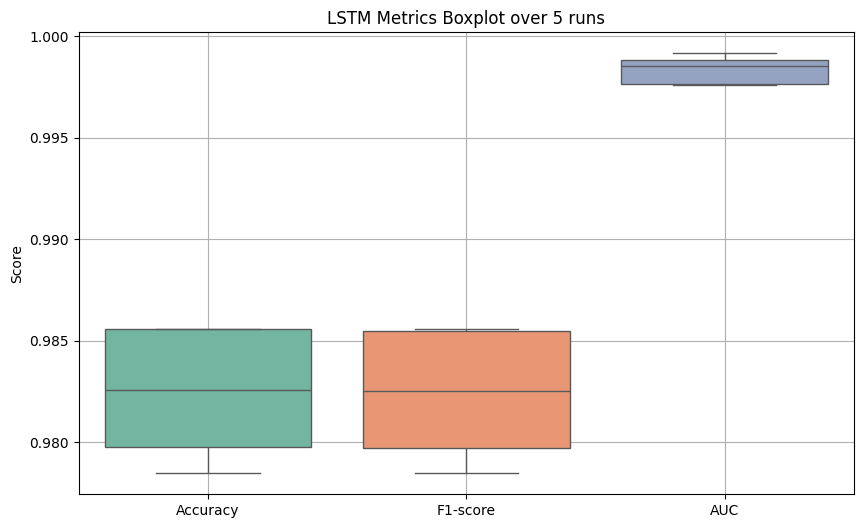


==== Training model: GRU ====
 Run 1/5
Epoch 1/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6987 - loss: 0.5395 - val_accuracy: 0.9035 - val_loss: 0.2700
Epoch 2/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8911 - loss: 0.2839 - val_accuracy: 0.9190 - val_loss: 0.2016
Epoch 3/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9164 - loss: 0.2255 - val_accuracy: 0.9268 - val_loss: 0.1760
Epoch 4/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9288 - loss: 0.1921 - val_accuracy: 0.9360 - val_loss: 0.1550
Epoch 5/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9347 - loss: 0.1757 - val_accuracy: 0.9446 - val_loss: 0.1362
Epoch 6/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9396 - loss: 0.1621 - val_accuracy: 0.9442 - val_loss: 0.1377
Epoch 7/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9456 - loss: 0.1457 - val_accuracy: 0.9563 - val_loss: 0.1176
Epoch 8/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 

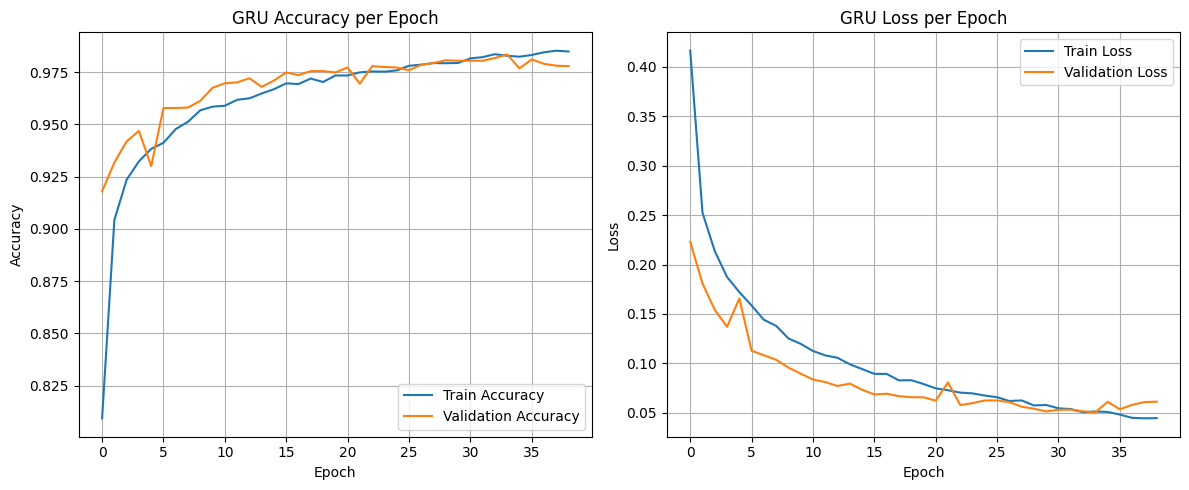


==== Summary for GRU (over 5 runs) ====
Accuracy: 0.9813 ± 0.0029
Precision: 0.9837 ± 0.0015
Recall: 0.9788 ± 0.0052
F1: 0.9812 ± 0.0029
Auc: 0.9982 ± 0.0005


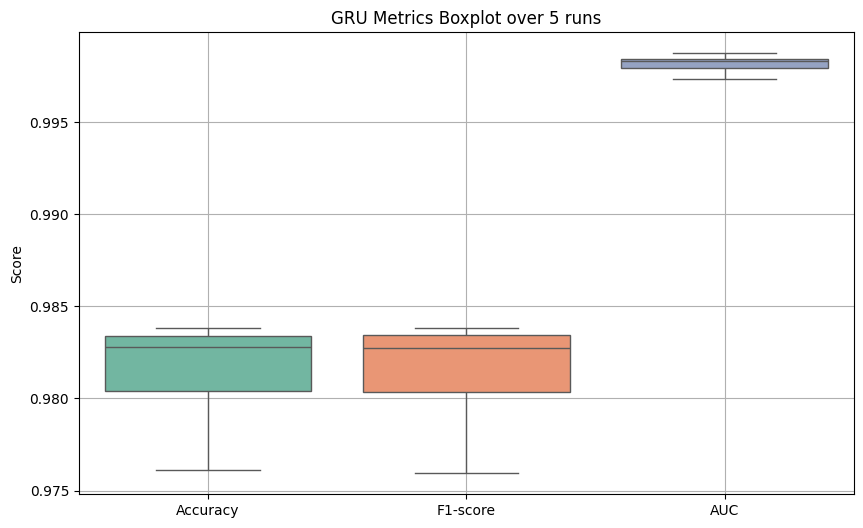


==== Training model: LSTM_GRU ====
 Run 1/5
Epoch 1/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.6675 - loss: 0.6068 - val_accuracy: 0.9001 - val_loss: 0.2861
Epoch 2/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8906 - loss: 0.3108 - val_accuracy: 0.9229 - val_loss: 0.2024
Epoch 3/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9214 - loss: 0.2298 - val_accuracy: 0.9324 - val_loss: 0.1732
Epoch 4/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9326 - loss: 0.1986 - val_accuracy: 0.9451 - val_loss: 0.1497
Epoch 5/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9403 - loss: 0.1760 - val_accuracy: 0.9526 - val_loss: 0.1346
Epoch 6/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9458 - loss: 0.1581 - val_accuracy: 0.9569 - val_loss: 0.1221
Epoch 7/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9494 - loss: 0.1481 - val_accuracy: 0.9602 - val_loss: 0.1164
Epoch 8/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/ste

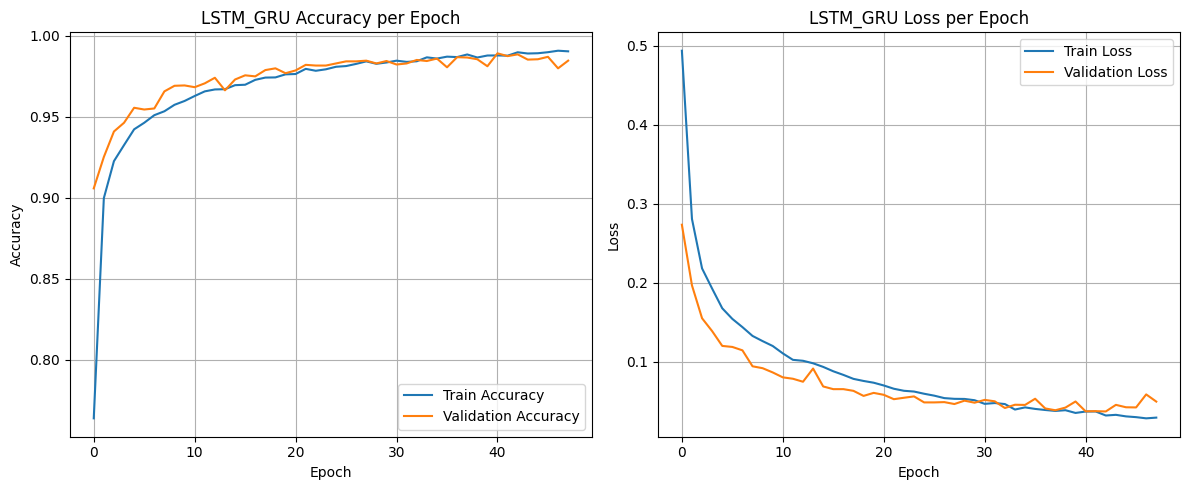


==== Summary for LSTM_GRU (over 5 runs) ====
Accuracy: 0.9842 ± 0.0049
Precision: 0.9842 ± 0.0050
Recall: 0.9842 ± 0.0054
F1: 0.9842 ± 0.0049
Auc: 0.9983 ± 0.0009


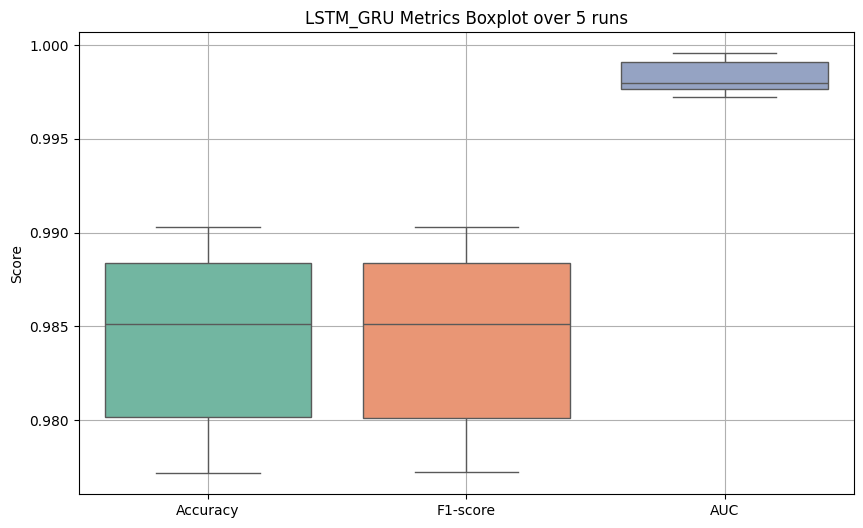


==== Training model: SimpleRNN ====
 Run 1/5
Epoch 1/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7055 - loss: 0.5381 - val_accuracy: 0.8977 - val_loss: 0.2650
Epoch 2/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8771 - loss: 0.3012 - val_accuracy: 0.9029 - val_loss: 0.2306
Epoch 3/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8997 - loss: 0.2478 - val_accuracy: 0.9255 - val_loss: 0.1861
Epoch 4/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9180 - loss: 0.2183 - val_accuracy: 0.9268 - val_loss: 0.1755
Epoch 5/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9301 - loss: 0.1911 - val_accuracy: 0.9399 - val_loss: 0.1556
Epoch 6/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9322 - loss: 0.1797 - val_accuracy: 0.9350 - val_loss: 0.1588
Epoch 7/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9399 - loss: 0.1652 - val_accuracy: 0.9481 - val_loss: 0.1373
Epoch 8/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accu

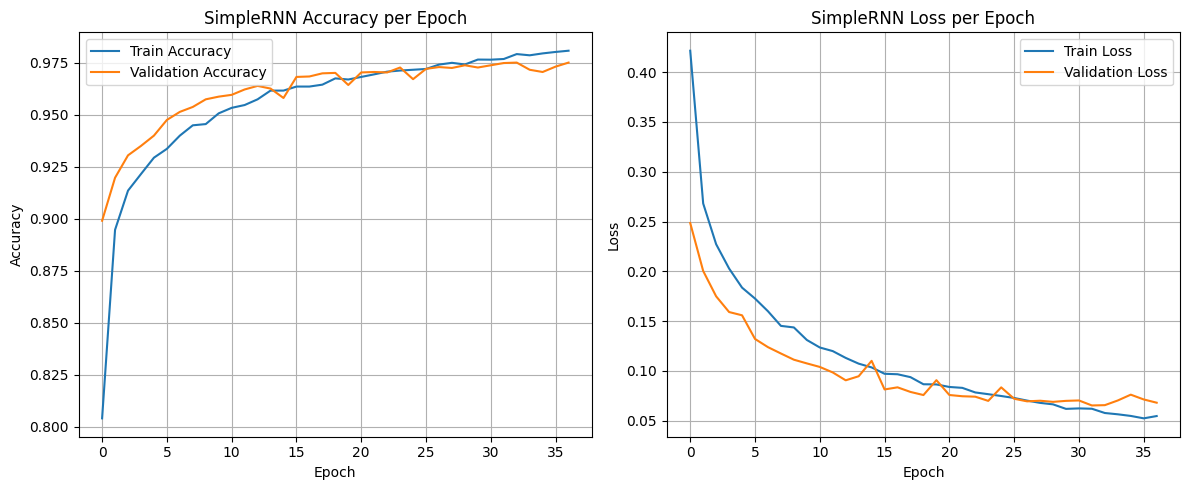


==== Summary for SimpleRNN (over 5 runs) ====
Accuracy: 0.9747 ± 0.0015
Precision: 0.9759 ± 0.0028
Recall: 0.9735 ± 0.0028
F1: 0.9747 ± 0.0015
Auc: 0.9970 ± 0.0006


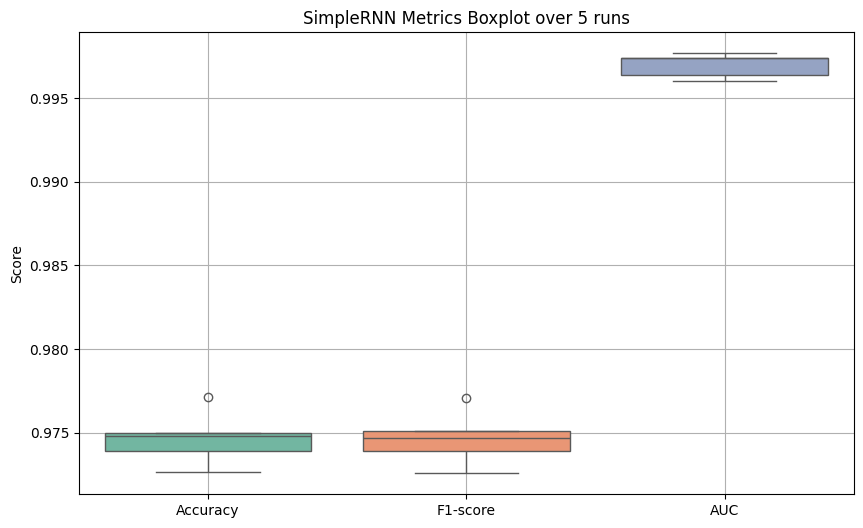


==== Training model: Dense ====
 Run 1/5
Epoch 1/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5842 - loss: 0.6711 - val_accuracy: 0.8451 - val_loss: 0.3985
Epoch 2/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7907 - loss: 0.4461 - val_accuracy: 0.8878 - val_loss: 0.3064
Epoch 3/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8453 - loss: 0.3610 - val_accuracy: 0.9005 - val_loss: 0.2810
Epoch 4/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8680 - loss: 0.3174 - val_accuracy: 0.8930 - val_loss: 0.2648
Epoch 5/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8887 - loss: 0.2896 - val_accuracy: 0.9072 - val_loss: 0.2218
Epoch 6/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8942 - loss: 0.2725 - val_accuracy: 0.9102 - val_loss: 0.2149
Epoch 7/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9011 - loss: 0.2568 - val_accuracy: 0.9117 - val_loss: 0.2041
Epoch 8/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy

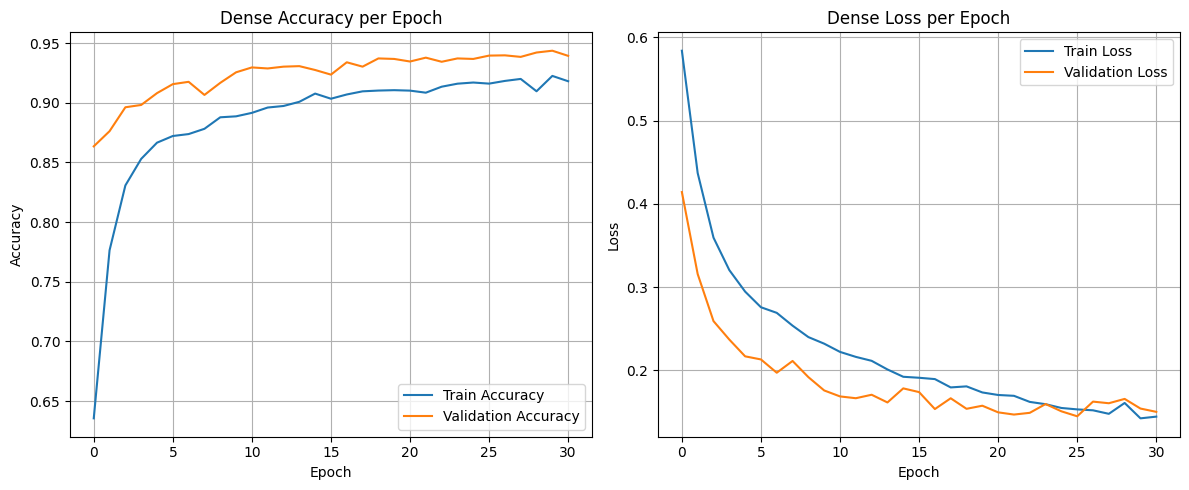


==== Summary for Dense (over 5 runs) ====
Accuracy: 0.9383 ± 0.0045
Precision: 0.9545 ± 0.0075
Recall: 0.9205 ± 0.0116
F1: 0.9371 ± 0.0049
Auc: 0.9862 ± 0.0013


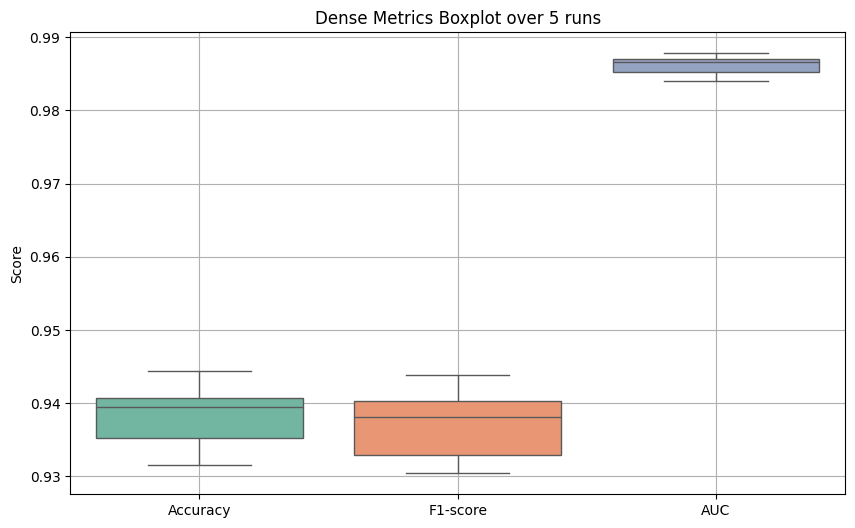


All run results saved to: /content/drive/MyDrive/AVA/results_all_models_repvgg_a0.csv


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, GRU, SimpleRNN, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, auc
)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import gc
from tensorflow.keras import backend as K

os.environ["CUDA_VISIBLE_DEVICES"] = ""

# --- Data loading and preprocessing ---
def prepare_data(normal_path, anomaly_path):
    X_normal = np.load(normal_path, allow_pickle=True)
    if X_normal.ndim >= 4:
        X_normal = X_normal.mean(axis=(2, 3))
    X_anomaly = np.load(anomaly_path, allow_pickle=True)
    if X_anomaly.ndim >= 4:
        X_anomaly = X_anomaly.mean(axis=(2, 3))
    X = np.concatenate([X_normal, X_anomaly])
    y = np.concatenate([np.zeros(len(X_normal)), np.ones(len(X_anomaly))])
    X = X.astype(np.float32)
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    X, y = shuffle(X, y, random_state=42)
    return X, y

def create_sequences(X, y, seq_len=5):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len + 1):
        X_seq.append(X[i:i + seq_len])
        y_seq.append(y[i + seq_len - 1])
    return np.array(X_seq), np.array(y_seq)

# --- Model builders with 32 and 16 units ---
def build_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(32, activation='tanh', recurrent_activation='sigmoid', unroll=True)(inputs)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_gru_model(input_shape):
    inputs = Input(shape=input_shape)
    x = GRU(32)(inputs)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_lstm_gru_model(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(32, return_sequences=True, unroll=True)(inputs)
    x = Dropout(0.3)(x)
    x = GRU(32)(x)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_simple_rnn_model(input_shape):
    inputs = Input(shape=input_shape)
    x = SimpleRNN(32)(inputs)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_dense_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Flatten()(inputs)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# --- Main execution ---
def main():
    feature_model_name = 'repvgg_a0'  # Change if needed
    seq_len = 10
    save_dir = '/content/drive/MyDrive/AVA'  # Change to your data path
    normal_path = f"{save_dir}/normal_features_{feature_model_name}.npy"
    anomaly_path = f"{save_dir}/anomaly_features_{feature_model_name}.npy"

    X, y = prepare_data(normal_path, anomaly_path)
    X_seq, y_seq = create_sequences(X, y, seq_len=seq_len)

    model_builders = {
        "LSTM": build_lstm_model,
        "GRU": build_gru_model,
        "LSTM_GRU": build_lstm_gru_model,
        "SimpleRNN": build_simple_rnn_model,
        "Dense": build_dense_model
    }

    num_runs = 5
    all_results = []

    for model_name, builder in model_builders.items():
        print(f"\n==== Training model: {model_name} ====")

        metrics_list = {
            "accuracy": [],
            "precision": [],
            "recall": [],
            "f1": [],
            "auc": []
        }

        histories = []

        for run in range(num_runs):
            print(f" Run {run+1}/{num_runs}")

            X_train, X_test, y_train, y_test = train_test_split(
                X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=run
            )

            model = builder(X_train.shape[1:])
            es = EarlyStopping(patience=5, restore_best_weights=True, verbose=0)
            history = model.fit(
                X_train, y_train,
                validation_data=(X_test, y_test),
                epochs=50,
                batch_size=32,
                callbacks=[es],
                verbose=1
            )
            histories.append(history)

            y_prob = model.predict(X_test).ravel()
            y_pred = (y_prob > 0.5).astype(int)

            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, zero_division=0)
            rec = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            auc_score = roc_auc_score(y_test, y_prob)

            # Store metrics
            metrics_list["accuracy"].append(acc)
            metrics_list["precision"].append(prec)
            metrics_list["recall"].append(rec)
            metrics_list["f1"].append(f1)
            metrics_list["auc"].append(auc_score)

            all_results.append({
                "Model": model_name,
                "Run": run + 1,
                "Accuracy": acc,
                "Precision": prec,
                "Recall": rec,
                "F1": f1,
                "AUC": auc_score
            })

            # Clear to save memory
            K.clear_session()
            del model
            gc.collect()

        # Plot training curves for last run
        last_history = histories[-1]
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(last_history.history['accuracy'], label='Train Accuracy')
        plt.plot(last_history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'{model_name} Accuracy per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.subplot(1,2,2)
        plt.plot(last_history.history['loss'], label='Train Loss')
        plt.plot(last_history.history['val_loss'], label='Validation Loss')
        plt.title(f'{model_name} Loss per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Print mean ± std summary for all runs
        print(f"\n==== Summary for {model_name} (over {num_runs} runs) ====")
        for metric in metrics_list:
            mean_val = np.mean(metrics_list[metric])
            std_val = np.std(metrics_list[metric])
            print(f"{metric.capitalize()}: {mean_val:.4f} ± {std_val:.4f}")

        # Plot boxplots of the 5 runs for metrics
        plt.figure(figsize=(10,6))
        sns.boxplot(data=[metrics_list["accuracy"], metrics_list["f1"], metrics_list["auc"]],
                    palette="Set2")
        plt.xticks([0,1,2], ['Accuracy', 'F1-score', 'AUC'])
        plt.title(f'{model_name} Metrics Boxplot over {num_runs} runs')
        plt.ylabel('Score')
        plt.grid(True)
        plt.show()

    # Save all results to CSV
    df = pd.DataFrame(all_results)
    csv_save_path = os.path.join(save_dir, f"results_all_models_{feature_model_name}.csv")
    df.to_csv(csv_save_path, index=False)
    print(f"\nAll run results saved to: {csv_save_path}")

if __name__ == "__main__":
    main()



==== Training model: LSTM ====
 Run 1/5
Epoch 1/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7032 - loss: 0.5629 - val_accuracy: 0.8889 - val_loss: 0.2885
Epoch 2/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8812 - loss: 0.3127 - val_accuracy: 0.9095 - val_loss: 0.2309
Epoch 3/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9068 - loss: 0.2527 - val_accuracy: 0.9225 - val_loss: 0.1956
Epoch 4/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9198 - loss: 0.2189 - val_accuracy: 0.9276 - val_loss: 0.1792
Epoch 5/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9303 - loss: 0.1961 - val_accuracy: 0.9306 - val_loss: 0.1673
Epoch 6/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9335 - loss: 0.1779 - val_accuracy: 0.9326 - val_loss: 0.1629
Epoch 7/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9361 - loss: 0.1739 - val_accuracy: 0.9371 - val_loss: 0.1545
Epoch 8/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy:

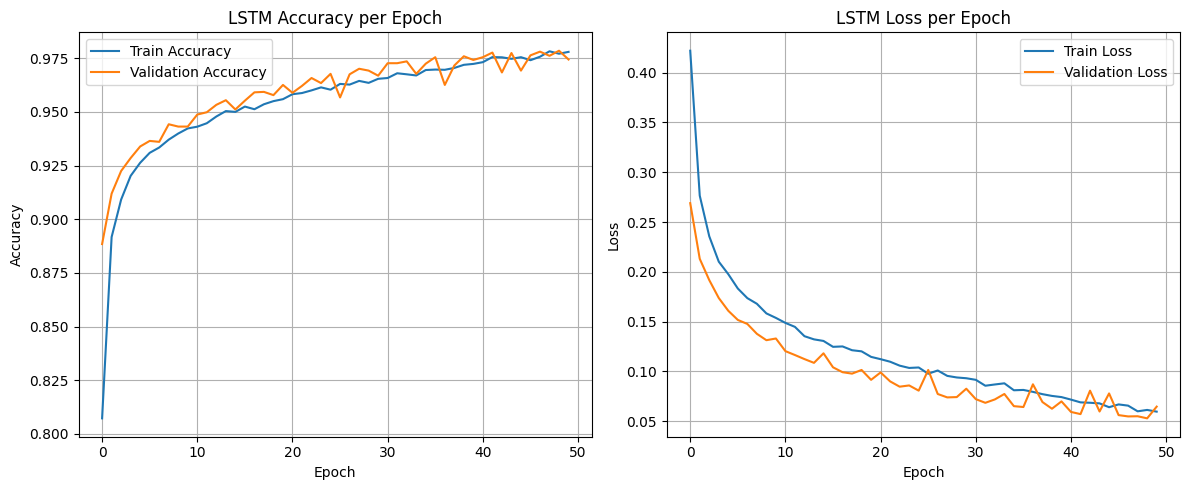


==== Summary for LSTM (over 5 runs) ====
Accuracy: 0.9754 ± 0.0043
Precision: 0.9799 ± 0.0067
Recall: 0.9707 ± 0.0029
F1: 0.9752 ± 0.0042
Auc: 0.9971 ± 0.0011


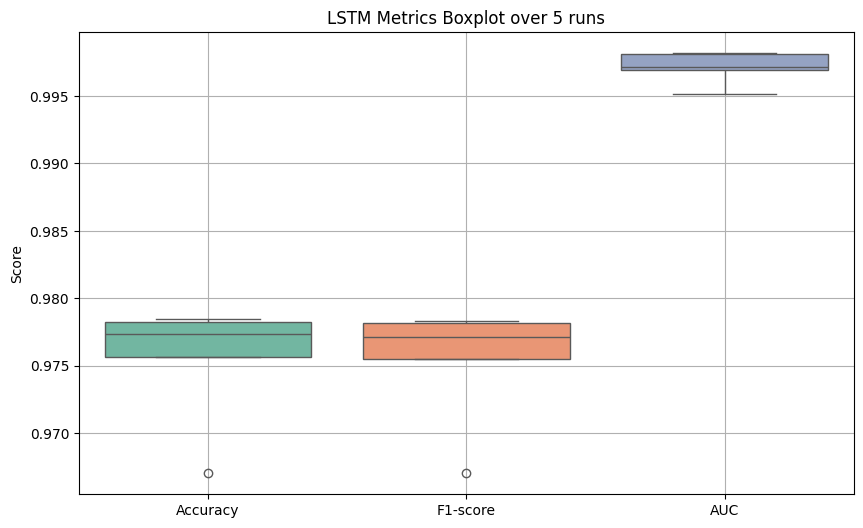


==== Training model: GRU ====
 Run 1/5
Epoch 1/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7118 - loss: 0.5357 - val_accuracy: 0.9031 - val_loss: 0.2495
Epoch 2/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8928 - loss: 0.2814 - val_accuracy: 0.9175 - val_loss: 0.2103
Epoch 3/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9104 - loss: 0.2350 - val_accuracy: 0.9253 - val_loss: 0.1835
Epoch 4/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9236 - loss: 0.2079 - val_accuracy: 0.9315 - val_loss: 0.1715
Epoch 5/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9230 - loss: 0.1960 - val_accuracy: 0.9300 - val_loss: 0.1681
Epoch 6/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9300 - loss: 0.1822 - val_accuracy: 0.9362 - val_loss: 0.1528
Epoch 7/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9374 - loss: 0.1681 - val_accuracy: 0.9358 - val_loss: 0.1489
Epoch 8/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 

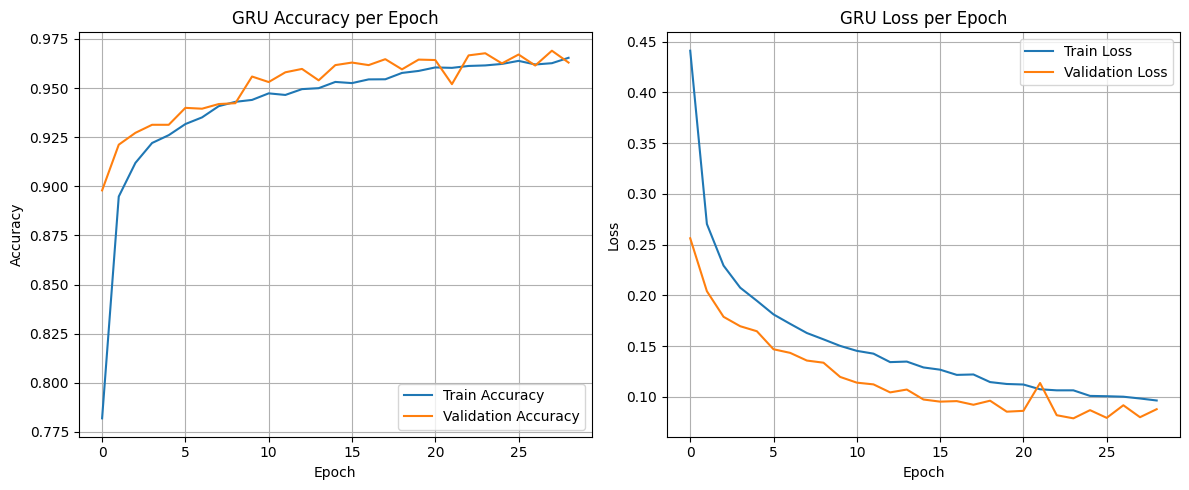


==== Summary for GRU (over 5 runs) ====
Accuracy: 0.9723 ± 0.0052
Precision: 0.9801 ± 0.0030
Recall: 0.9641 ± 0.0093
F1: 0.9720 ± 0.0054
Auc: 0.9965 ± 0.0009


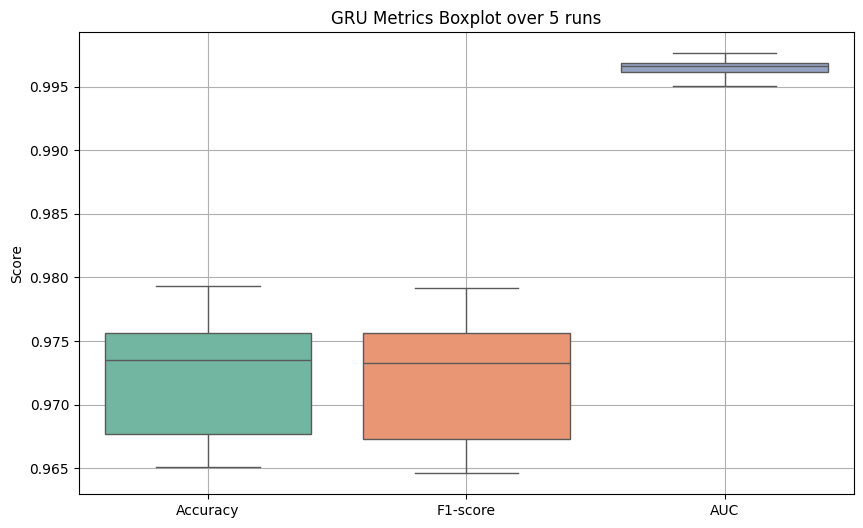


==== Training model: LSTM_GRU ====
 Run 1/5
Epoch 1/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.6453 - loss: 0.6136 - val_accuracy: 0.8762 - val_loss: 0.2956
Epoch 2/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8850 - loss: 0.3042 - val_accuracy: 0.9145 - val_loss: 0.2141
Epoch 3/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9129 - loss: 0.2436 - val_accuracy: 0.9190 - val_loss: 0.1978
Epoch 4/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9207 - loss: 0.2197 - val_accuracy: 0.9287 - val_loss: 0.1787
Epoch 5/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9278 - loss: 0.2029 - val_accuracy: 0.9334 - val_loss: 0.1709
Epoch 6/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9330 - loss: 0.1799 - val_accuracy: 0.9313 - val_loss: 0.1769
Epoch 7/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9387 - loss: 0.1757 - val_accuracy: 0.9373 - val_loss: 0.1605
Epoch 8/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/ste

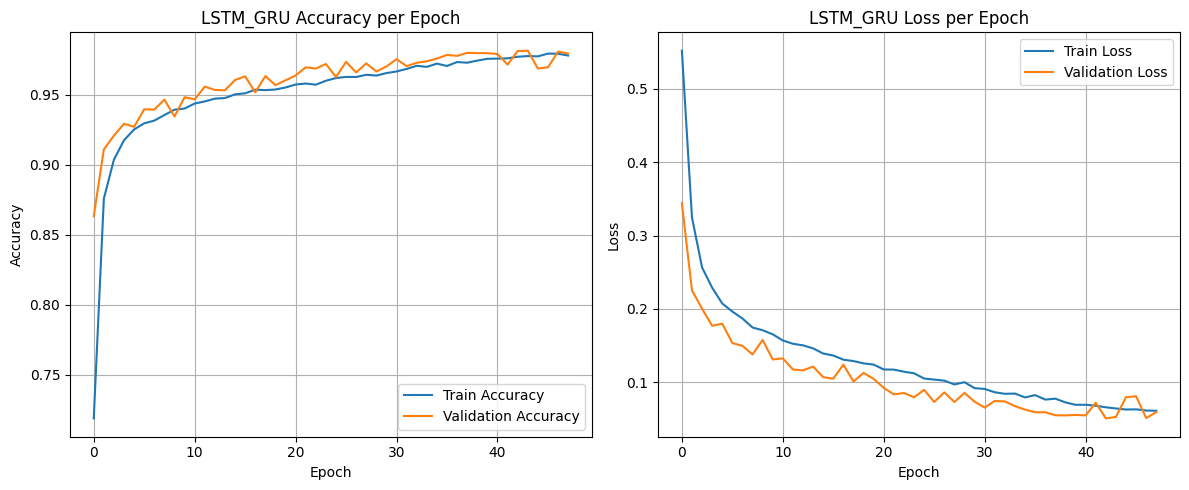


==== Summary for LSTM_GRU (over 5 runs) ====
Accuracy: 0.9810 ± 0.0015
Precision: 0.9819 ± 0.0036
Recall: 0.9802 ± 0.0016
F1: 0.9810 ± 0.0014
Auc: 0.9978 ± 0.0005


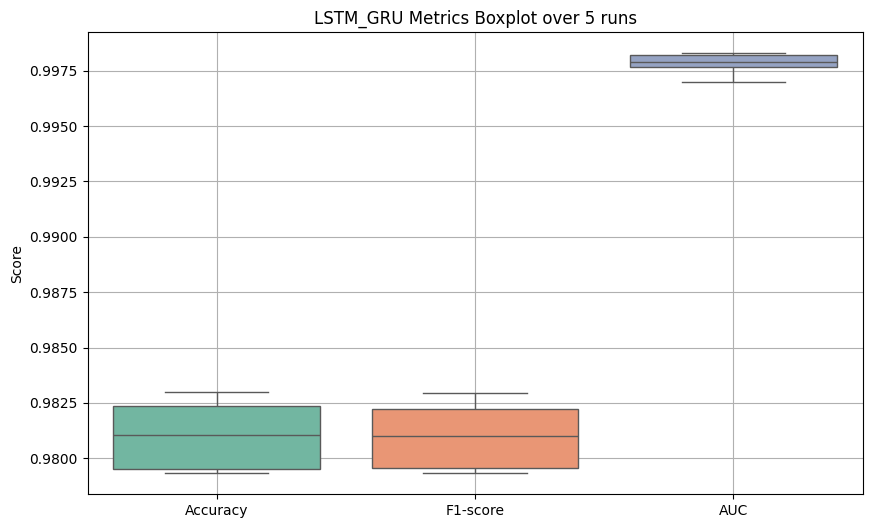


==== Training model: SimpleRNN ====
 Run 1/5
Epoch 1/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6949 - loss: 0.5692 - val_accuracy: 0.8783 - val_loss: 0.2886
Epoch 2/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8579 - loss: 0.3288 - val_accuracy: 0.9048 - val_loss: 0.2360
Epoch 3/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8922 - loss: 0.2749 - val_accuracy: 0.9190 - val_loss: 0.2051
Epoch 4/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9065 - loss: 0.2436 - val_accuracy: 0.9214 - val_loss: 0.1941
Epoch 5/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9120 - loss: 0.2287 - val_accuracy: 0.9250 - val_loss: 0.1820
Epoch 6/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9232 - loss: 0.2009 - val_accuracy: 0.9317 - val_loss: 0.1719
Epoch 7/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9218 - loss: 0.2037 - val_accuracy: 0.9322 - val_loss: 0.1655
Epoch 8/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accu

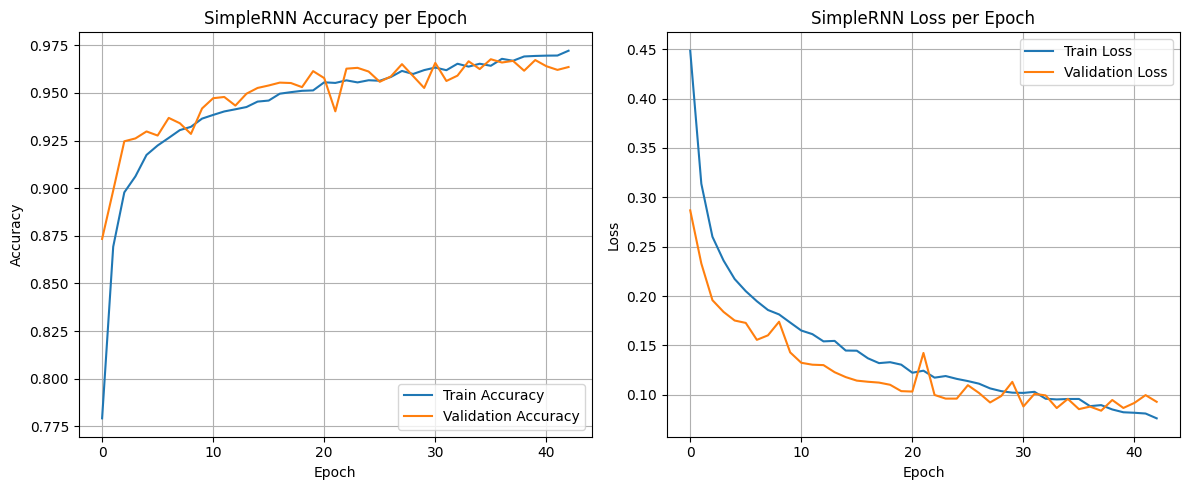


==== Summary for SimpleRNN (over 5 runs) ====
Accuracy: 0.9641 ± 0.0049
Precision: 0.9753 ± 0.0073
Recall: 0.9523 ± 0.0083
F1: 0.9636 ± 0.0049
Auc: 0.9944 ± 0.0013


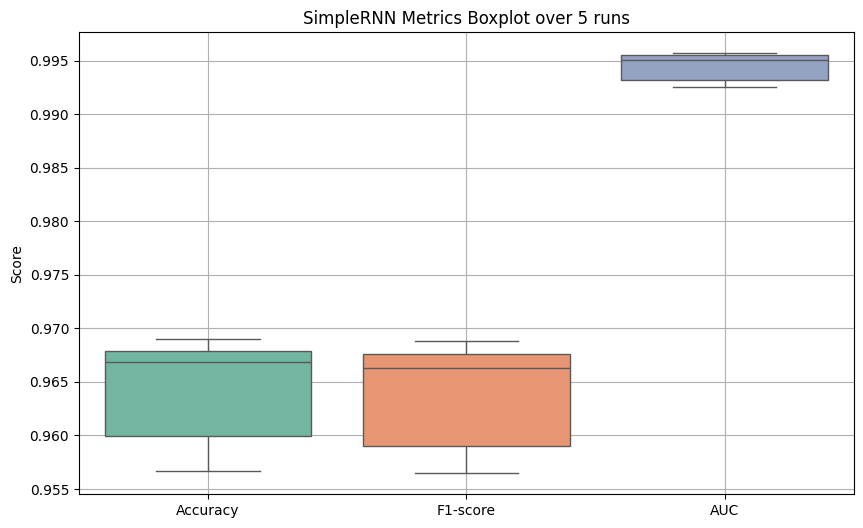


==== Training model: Dense ====
 Run 1/5
Epoch 1/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5968 - loss: 0.6366 - val_accuracy: 0.8352 - val_loss: 0.4230
Epoch 2/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7738 - loss: 0.4540 - val_accuracy: 0.8721 - val_loss: 0.3366
Epoch 3/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8306 - loss: 0.3788 - val_accuracy: 0.8596 - val_loss: 0.3122
Epoch 4/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8532 - loss: 0.3559 - val_accuracy: 0.9037 - val_loss: 0.2785
Epoch 5/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8779 - loss: 0.3206 - val_accuracy: 0.9005 - val_loss: 0.2709
Epoch 6/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8839 - loss: 0.3071 - val_accuracy: 0.9093 - val_loss: 0.2335
Epoch 7/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8965 - loss: 0.2844 - val_accuracy: 0.9136 - val_loss: 0.2294
Epoch 8/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy

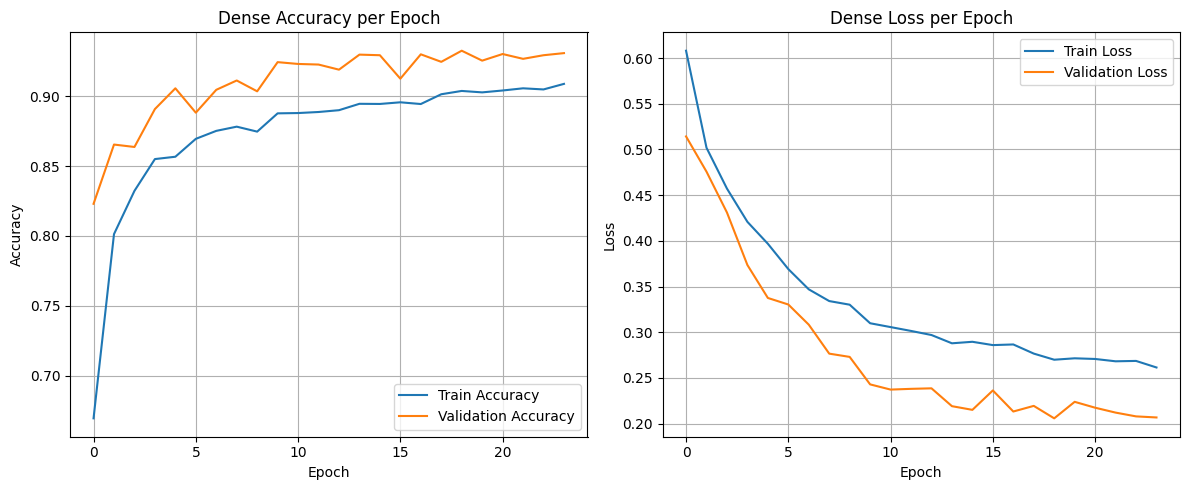


==== Summary for Dense (over 5 runs) ====
Accuracy: 0.9338 ± 0.0048
Precision: 0.9565 ± 0.0057
Recall: 0.9090 ± 0.0067
F1: 0.9321 ± 0.0050
Auc: 0.9805 ± 0.0054


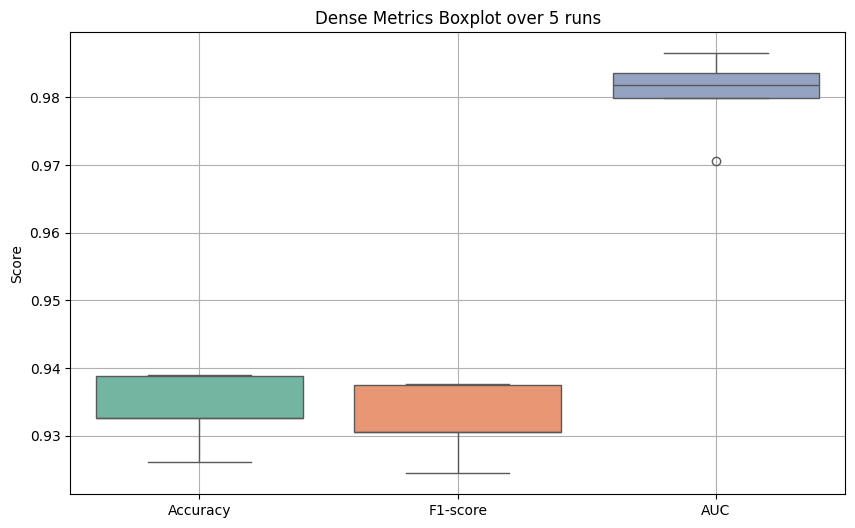


All run results saved to: /content/drive/MyDrive/AVA/results_all_models_mobileone_s0.csv


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, GRU, SimpleRNN, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, auc
)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import gc
from tensorflow.keras import backend as K

os.environ["CUDA_VISIBLE_DEVICES"] = ""

# --- Data loading and preprocessing ---
def prepare_data(normal_path, anomaly_path):
    X_normal = np.load(normal_path, allow_pickle=True)
    if X_normal.ndim >= 4:
        X_normal = X_normal.mean(axis=(2, 3))
    X_anomaly = np.load(anomaly_path, allow_pickle=True)
    if X_anomaly.ndim >= 4:
        X_anomaly = X_anomaly.mean(axis=(2, 3))
    X = np.concatenate([X_normal, X_anomaly])
    y = np.concatenate([np.zeros(len(X_normal)), np.ones(len(X_anomaly))])
    X = X.astype(np.float32)
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    X, y = shuffle(X, y, random_state=42)
    return X, y

def create_sequences(X, y, seq_len=5):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len + 1):
        X_seq.append(X[i:i + seq_len])
        y_seq.append(y[i + seq_len - 1])
    return np.array(X_seq), np.array(y_seq)

# --- Model builders with 32 and 16 units ---
def build_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(32, activation='tanh', recurrent_activation='sigmoid', unroll=True)(inputs)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_gru_model(input_shape):
    inputs = Input(shape=input_shape)
    x = GRU(32)(inputs)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_lstm_gru_model(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(32, return_sequences=True, unroll=True)(inputs)
    x = Dropout(0.3)(x)
    x = GRU(32)(x)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_simple_rnn_model(input_shape):
    inputs = Input(shape=input_shape)
    x = SimpleRNN(32)(inputs)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_dense_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Flatten()(inputs)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# --- Main execution ---
def main():
    feature_model_name = 'mobileone_s0'  # Change if needed
    seq_len = 10
    save_dir = '/content/drive/MyDrive/AVA'  # Change to your data path
    normal_path = f"{save_dir}/normal_features_{feature_model_name}.npy"
    anomaly_path = f"{save_dir}/anomaly_features_{feature_model_name}.npy"

    X, y = prepare_data(normal_path, anomaly_path)
    X_seq, y_seq = create_sequences(X, y, seq_len=seq_len)

    model_builders = {
        "LSTM": build_lstm_model,
        "GRU": build_gru_model,
        "LSTM_GRU": build_lstm_gru_model,
        "SimpleRNN": build_simple_rnn_model,
        "Dense": build_dense_model
    }

    num_runs = 5
    all_results = []

    for model_name, builder in model_builders.items():
        print(f"\n==== Training model: {model_name} ====")

        metrics_list = {
            "accuracy": [],
            "precision": [],
            "recall": [],
            "f1": [],
            "auc": []
        }

        histories = []

        for run in range(num_runs):
            print(f" Run {run+1}/{num_runs}")

            X_train, X_test, y_train, y_test = train_test_split(
                X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=run
            )

            model = builder(X_train.shape[1:])
            es = EarlyStopping(patience=5, restore_best_weights=True, verbose=0)
            history = model.fit(
                X_train, y_train,
                validation_data=(X_test, y_test),
                epochs=50,
                batch_size=32,
                callbacks=[es],
                verbose=1
            )
            histories.append(history)

            y_prob = model.predict(X_test).ravel()
            y_pred = (y_prob > 0.5).astype(int)

            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, zero_division=0)
            rec = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            auc_score = roc_auc_score(y_test, y_prob)

            # Store metrics
            metrics_list["accuracy"].append(acc)
            metrics_list["precision"].append(prec)
            metrics_list["recall"].append(rec)
            metrics_list["f1"].append(f1)
            metrics_list["auc"].append(auc_score)

            all_results.append({
                "Model": model_name,
                "Run": run + 1,
                "Accuracy": acc,
                "Precision": prec,
                "Recall": rec,
                "F1": f1,
                "AUC": auc_score
            })

            # Clear to save memory
            K.clear_session()
            del model
            gc.collect()

        # Plot training curves for last run
        last_history = histories[-1]
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(last_history.history['accuracy'], label='Train Accuracy')
        plt.plot(last_history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'{model_name} Accuracy per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.subplot(1,2,2)
        plt.plot(last_history.history['loss'], label='Train Loss')
        plt.plot(last_history.history['val_loss'], label='Validation Loss')
        plt.title(f'{model_name} Loss per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Print mean ± std summary for all runs
        print(f"\n==== Summary for {model_name} (over {num_runs} runs) ====")
        for metric in metrics_list:
            mean_val = np.mean(metrics_list[metric])
            std_val = np.std(metrics_list[metric])
            print(f"{metric.capitalize()}: {mean_val:.4f} ± {std_val:.4f}")

        # Plot boxplots of the 5 runs for metrics
        plt.figure(figsize=(10,6))
        sns.boxplot(data=[metrics_list["accuracy"], metrics_list["f1"], metrics_list["auc"]],
                    palette="Set2")
        plt.xticks([0,1,2], ['Accuracy', 'F1-score', 'AUC'])
        plt.title(f'{model_name} Metrics Boxplot over {num_runs} runs')
        plt.ylabel('Score')
        plt.grid(True)
        plt.show()

    # Save all results to CSV
    df = pd.DataFrame(all_results)
    csv_save_path = os.path.join(save_dir, f"results_all_models_{feature_model_name}.csv")
    df.to_csv(csv_save_path, index=False)
    print(f"\nAll run results saved to: {csv_save_path}")

if __name__ == "__main__":
    main()



==== Training model: LSTM ====
 Run 1/5
Epoch 1/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6837 - loss: 0.5836 - val_accuracy: 0.8938 - val_loss: 0.2936
Epoch 2/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8919 - loss: 0.2966 - val_accuracy: 0.9179 - val_loss: 0.2148
Epoch 3/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9136 - loss: 0.2297 - val_accuracy: 0.9233 - val_loss: 0.1942
Epoch 4/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9190 - loss: 0.2184 - val_accuracy: 0.9235 - val_loss: 0.1826
Epoch 5/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9244 - loss: 0.1971 - val_accuracy: 0.9266 - val_loss: 0.1709
Epoch 6/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9297 - loss: 0.1859 - val_accuracy: 0.9332 - val_loss: 0.1620
Epoch 7/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9349 - loss: 0.1690 - val_accuracy: 0.9378 - val_loss: 0.1544
Epoch 8/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy:

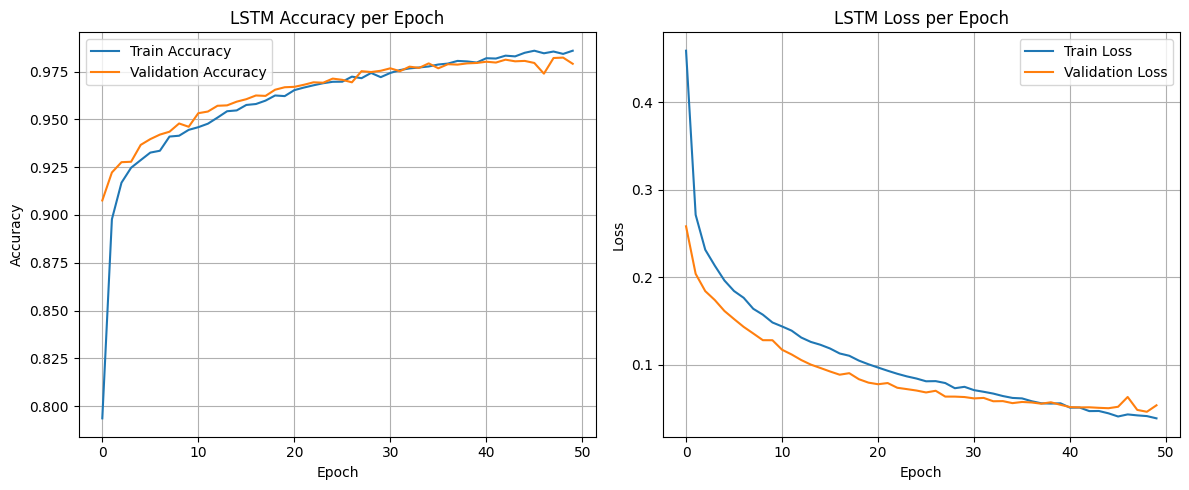


==== Summary for LSTM (over 5 runs) ====
Accuracy: 0.9781 ± 0.0026
Precision: 0.9806 ± 0.0018
Recall: 0.9755 ± 0.0041
F1: 0.9781 ± 0.0026
Auc: 0.9977 ± 0.0006


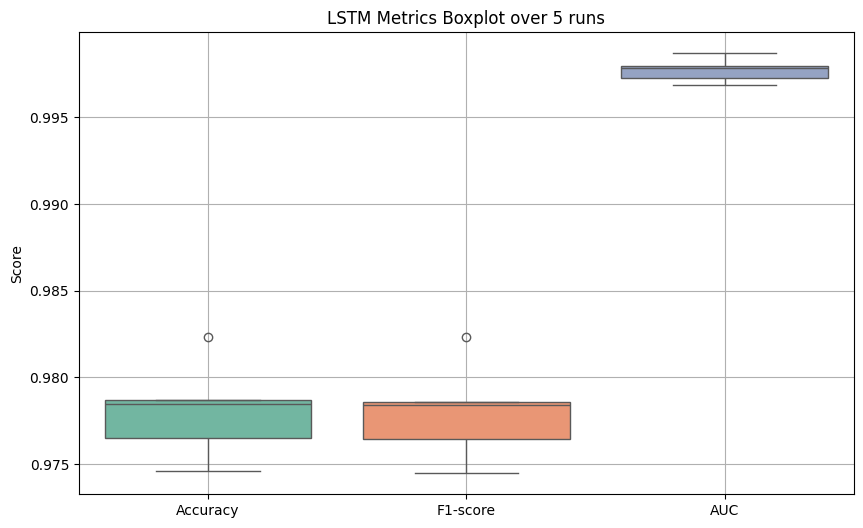


==== Training model: GRU ====
 Run 1/5
Epoch 1/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6804 - loss: 0.5721 - val_accuracy: 0.9074 - val_loss: 0.2475
Epoch 2/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8962 - loss: 0.2753 - val_accuracy: 0.9205 - val_loss: 0.2019
Epoch 3/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9147 - loss: 0.2280 - val_accuracy: 0.9259 - val_loss: 0.1896
Epoch 4/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9206 - loss: 0.2058 - val_accuracy: 0.9304 - val_loss: 0.1747
Epoch 5/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9253 - loss: 0.1933 - val_accuracy: 0.9313 - val_loss: 0.1655
Epoch 6/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9316 - loss: 0.1767 - val_accuracy: 0.9354 - val_loss: 0.1563
Epoch 7/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9334 - loss: 0.1721 - val_accuracy: 0.9356 - val_loss: 0.1531
Epoch 8/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 

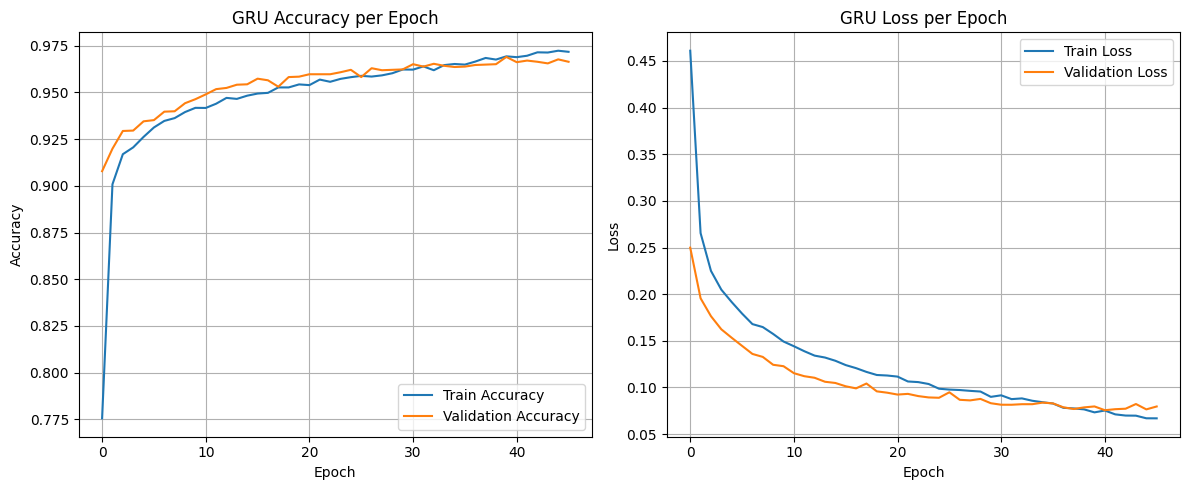


==== Summary for GRU (over 5 runs) ====
Accuracy: 0.9689 ± 0.0019
Precision: 0.9742 ± 0.0049
Recall: 0.9632 ± 0.0043
F1: 0.9687 ± 0.0019
Auc: 0.9963 ± 0.0004


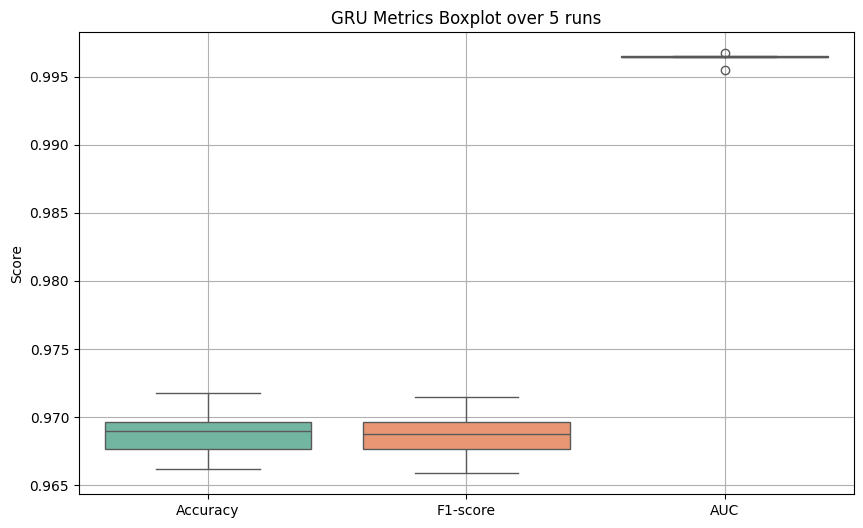


==== Training model: LSTM_GRU ====
 Run 1/5
Epoch 1/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.5921 - loss: 0.6592 - val_accuracy: 0.8968 - val_loss: 0.3148
Epoch 2/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8799 - loss: 0.3334 - val_accuracy: 0.9212 - val_loss: 0.2123
Epoch 3/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9127 - loss: 0.2522 - val_accuracy: 0.9238 - val_loss: 0.2108
Epoch 4/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9237 - loss: 0.2151 - val_accuracy: 0.9291 - val_loss: 0.1833
Epoch 5/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9292 - loss: 0.2066 - val_accuracy: 0.9345 - val_loss: 0.1739
Epoch 6/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9308 - loss: 0.1958 - val_accuracy: 0.9362 - val_loss: 0.1683
Epoch 7/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9352 - loss: 0.1882 - val_accuracy: 0.9416 - val_loss: 0.1580
Epoch 8/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - ac

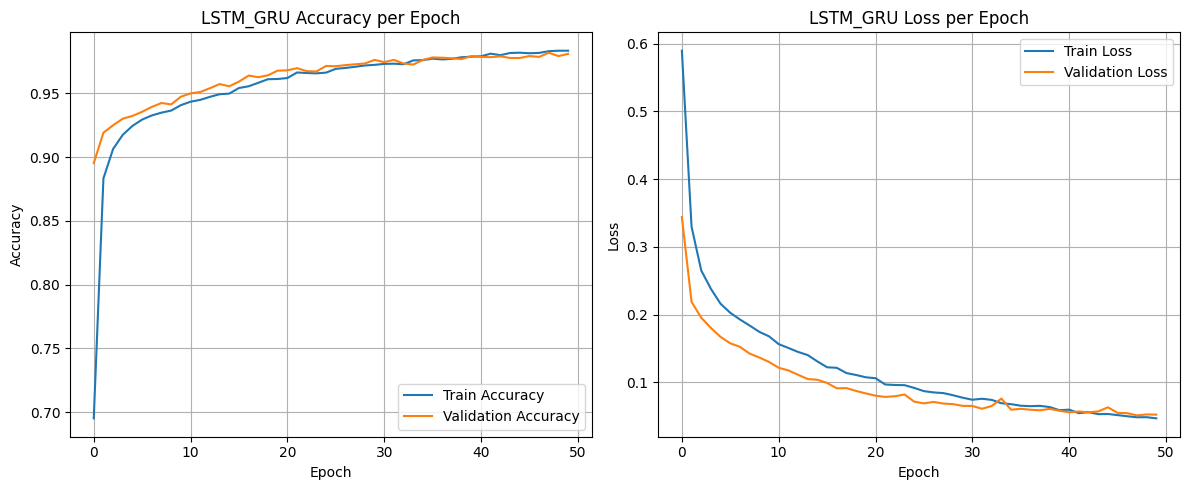


==== Summary for LSTM_GRU (over 5 runs) ====
Accuracy: 0.9833 ± 0.0028
Precision: 0.9840 ± 0.0017
Recall: 0.9825 ± 0.0041
F1: 0.9833 ± 0.0028
Auc: 0.9982 ± 0.0007


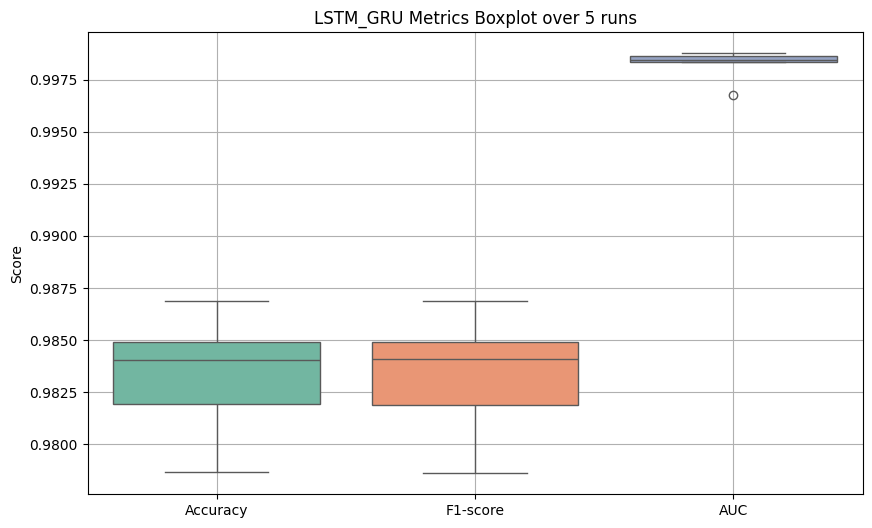


==== Training model: SimpleRNN ====
 Run 1/5
Epoch 1/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7111 - loss: 0.5452 - val_accuracy: 0.9026 - val_loss: 0.2702
Epoch 2/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8722 - loss: 0.3158 - val_accuracy: 0.9067 - val_loss: 0.2312
Epoch 3/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8966 - loss: 0.2618 - val_accuracy: 0.9158 - val_loss: 0.2100
Epoch 4/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9064 - loss: 0.2499 - val_accuracy: 0.9201 - val_loss: 0.1954
Epoch 5/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9163 - loss: 0.2278 - val_accuracy: 0.9250 - val_loss: 0.1870
Epoch 6/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9206 - loss: 0.2079 - val_accuracy: 0.9287 - val_loss: 0.1806
Epoch 7/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9239 - loss: 0.1981 - val_accuracy: 0.9300 - val_loss: 0.1745
Epoch 8/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accu

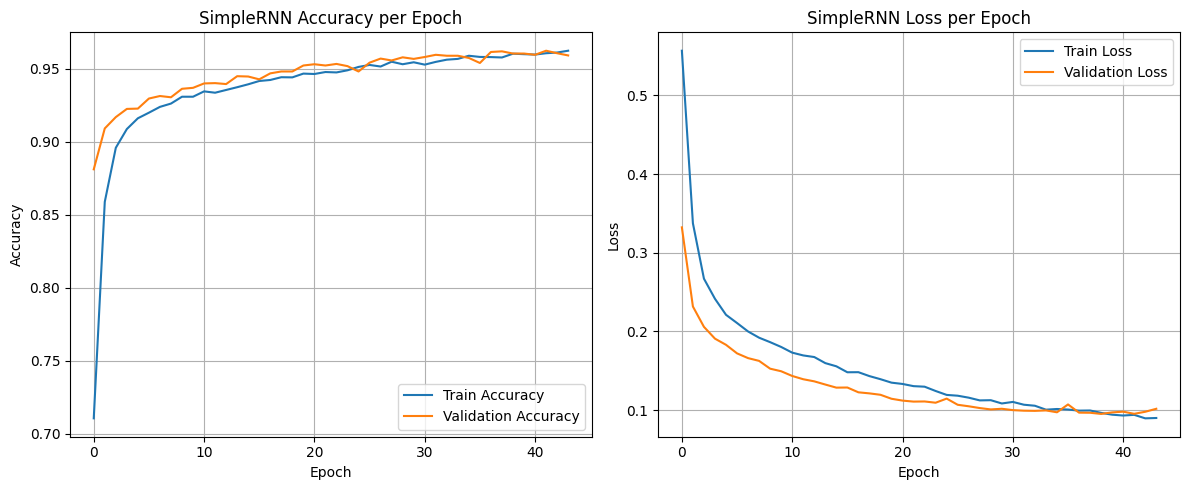


==== Summary for SimpleRNN (over 5 runs) ====
Accuracy: 0.9583 ± 0.0028
Precision: 0.9695 ± 0.0039
Recall: 0.9465 ± 0.0033
F1: 0.9578 ± 0.0028
Auc: 0.9938 ± 0.0007


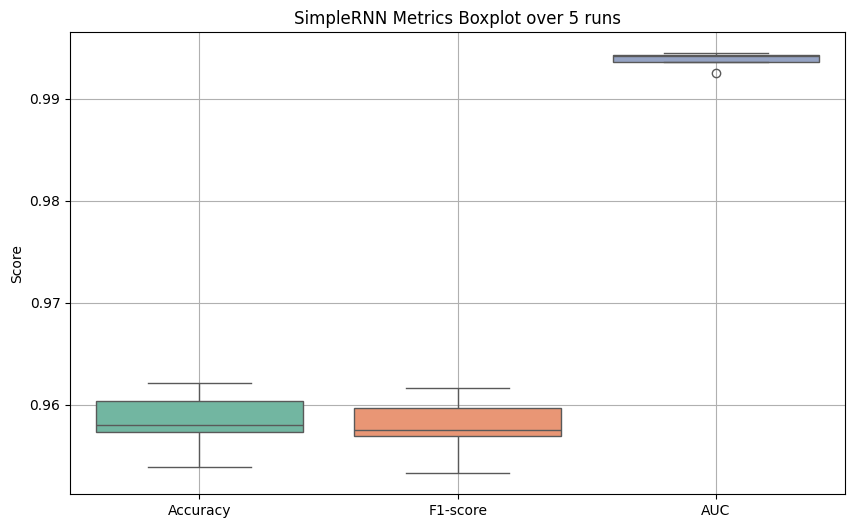


==== Training model: Dense ====
 Run 1/5
Epoch 1/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6263 - loss: 0.6274 - val_accuracy: 0.8755 - val_loss: 0.3683
Epoch 2/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8123 - loss: 0.4153 - val_accuracy: 0.9044 - val_loss: 0.2797
Epoch 3/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8720 - loss: 0.3209 - val_accuracy: 0.9070 - val_loss: 0.2421
Epoch 4/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8871 - loss: 0.2812 - val_accuracy: 0.9080 - val_loss: 0.2270
Epoch 5/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9053 - loss: 0.2560 - val_accuracy: 0.9126 - val_loss: 0.2162
Epoch 6/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9089 - loss: 0.2374 - val_accuracy: 0.9149 - val_loss: 0.2036
Epoch 7/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9133 - loss: 0.2190 - val_accuracy: 0.9190 - val_loss: 0.2023
Epoch 8/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy

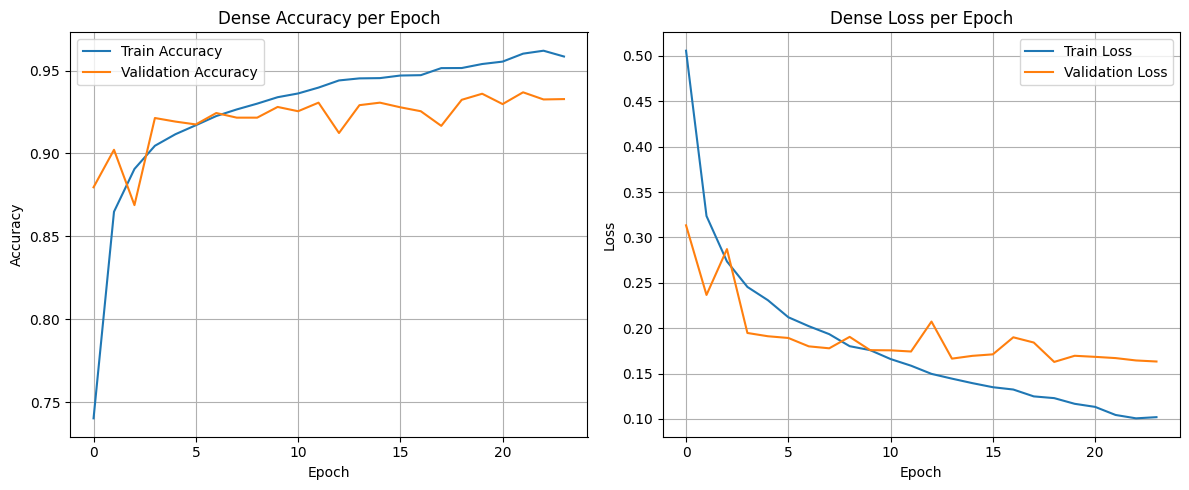


==== Summary for Dense (over 5 runs) ====
Accuracy: 0.9300 ± 0.0046
Precision: 0.9529 ± 0.0059
Recall: 0.9049 ± 0.0107
F1: 0.9282 ± 0.0051
Auc: 0.9819 ± 0.0021


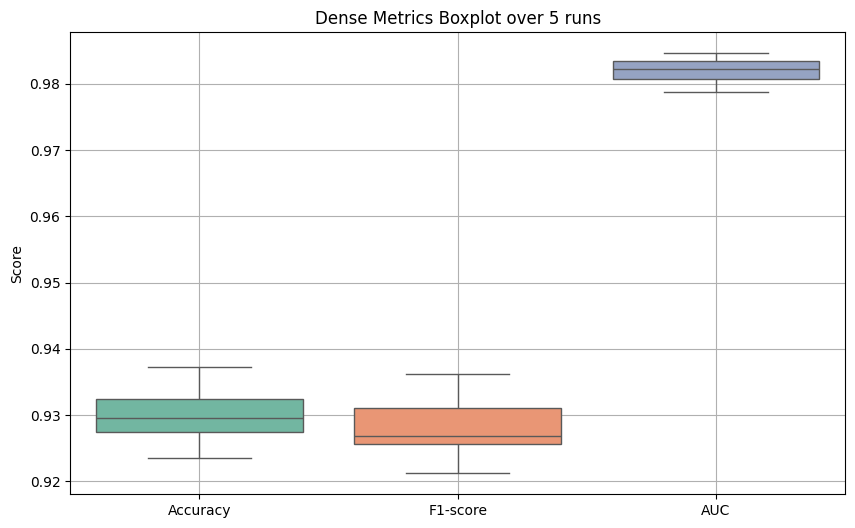


All run results saved to: /content/drive/MyDrive/AVA/results_all_models_poolformer_s12.csv


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, GRU, SimpleRNN, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, auc
)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import gc
from tensorflow.keras import backend as K

os.environ["CUDA_VISIBLE_DEVICES"] = ""

# --- Data loading and preprocessing ---
def prepare_data(normal_path, anomaly_path):
    X_normal = np.load(normal_path, allow_pickle=True)
    if X_normal.ndim >= 4:
        X_normal = X_normal.mean(axis=(2, 3))
    X_anomaly = np.load(anomaly_path, allow_pickle=True)
    if X_anomaly.ndim >= 4:
        X_anomaly = X_anomaly.mean(axis=(2, 3))
    X = np.concatenate([X_normal, X_anomaly])
    y = np.concatenate([np.zeros(len(X_normal)), np.ones(len(X_anomaly))])
    X = X.astype(np.float32)
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    X, y = shuffle(X, y, random_state=42)
    return X, y

def create_sequences(X, y, seq_len=5):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len + 1):
        X_seq.append(X[i:i + seq_len])
        y_seq.append(y[i + seq_len - 1])
    return np.array(X_seq), np.array(y_seq)

# --- Model builders with 32 and 16 units ---
def build_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(32, activation='tanh', recurrent_activation='sigmoid', unroll=True)(inputs)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_gru_model(input_shape):
    inputs = Input(shape=input_shape)
    x = GRU(32)(inputs)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_lstm_gru_model(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(32, return_sequences=True, unroll=True)(inputs)
    x = Dropout(0.3)(x)
    x = GRU(32)(x)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_simple_rnn_model(input_shape):
    inputs = Input(shape=input_shape)
    x = SimpleRNN(32)(inputs)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_dense_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Flatten()(inputs)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# --- Main execution ---
def main():
    feature_model_name = 'poolformer_s12'  # Change if needed
    seq_len = 10
    save_dir = '/content/drive/MyDrive/AVA'  # Change to your data path
    normal_path = f"{save_dir}/normal_features_{feature_model_name}.npy"
    anomaly_path = f"{save_dir}/anomaly_features_{feature_model_name}.npy"

    X, y = prepare_data(normal_path, anomaly_path)
    X_seq, y_seq = create_sequences(X, y, seq_len=seq_len)

    model_builders = {
        "LSTM": build_lstm_model,
        "GRU": build_gru_model,
        "LSTM_GRU": build_lstm_gru_model,
        "SimpleRNN": build_simple_rnn_model,
        "Dense": build_dense_model
    }

    num_runs = 5
    all_results = []

    for model_name, builder in model_builders.items():
        print(f"\n==== Training model: {model_name} ====")

        metrics_list = {
            "accuracy": [],
            "precision": [],
            "recall": [],
            "f1": [],
            "auc": []
        }

        histories = []

        for run in range(num_runs):
            print(f" Run {run+1}/{num_runs}")

            X_train, X_test, y_train, y_test = train_test_split(
                X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=run
            )

            model = builder(X_train.shape[1:])
            es = EarlyStopping(patience=5, restore_best_weights=True, verbose=0)
            history = model.fit(
                X_train, y_train,
                validation_data=(X_test, y_test),
                epochs=50,
                batch_size=32,
                callbacks=[es],
                verbose=1
            )
            histories.append(history)

            y_prob = model.predict(X_test).ravel()
            y_pred = (y_prob > 0.5).astype(int)

            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, zero_division=0)
            rec = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            auc_score = roc_auc_score(y_test, y_prob)

            # Store metrics
            metrics_list["accuracy"].append(acc)
            metrics_list["precision"].append(prec)
            metrics_list["recall"].append(rec)
            metrics_list["f1"].append(f1)
            metrics_list["auc"].append(auc_score)

            all_results.append({
                "Model": model_name,
                "Run": run + 1,
                "Accuracy": acc,
                "Precision": prec,
                "Recall": rec,
                "F1": f1,
                "AUC": auc_score
            })

            # Clear to save memory
            K.clear_session()
            del model
            gc.collect()

        # Plot training curves for last run
        last_history = histories[-1]
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(last_history.history['accuracy'], label='Train Accuracy')
        plt.plot(last_history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'{model_name} Accuracy per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.subplot(1,2,2)
        plt.plot(last_history.history['loss'], label='Train Loss')
        plt.plot(last_history.history['val_loss'], label='Validation Loss')
        plt.title(f'{model_name} Loss per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Print mean ± std summary for all runs
        print(f"\n==== Summary for {model_name} (over {num_runs} runs) ====")
        for metric in metrics_list:
            mean_val = np.mean(metrics_list[metric])
            std_val = np.std(metrics_list[metric])
            print(f"{metric.capitalize()}: {mean_val:.4f} ± {std_val:.4f}")

        # Plot boxplots of the 5 runs for metrics
        plt.figure(figsize=(10,6))
        sns.boxplot(data=[metrics_list["accuracy"], metrics_list["f1"], metrics_list["auc"]],
                    palette="Set2")
        plt.xticks([0,1,2], ['Accuracy', 'F1-score', 'AUC'])
        plt.title(f'{model_name} Metrics Boxplot over {num_runs} runs')
        plt.ylabel('Score')
        plt.grid(True)
        plt.show()

    # Save all results to CSV
    df = pd.DataFrame(all_results)
    csv_save_path = os.path.join(save_dir, f"results_all_models_{feature_model_name}.csv")
    df.to_csv(csv_save_path, index=False)
    print(f"\nAll run results saved to: {csv_save_path}")

if __name__ == "__main__":
    main()



==== Training model: LSTM ====
 Run 1/5
Epoch 1/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6438 - loss: 0.6228 - val_accuracy: 0.8710 - val_loss: 0.3372
Epoch 2/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8595 - loss: 0.3494 - val_accuracy: 0.8970 - val_loss: 0.2526
Epoch 3/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8875 - loss: 0.2863 - val_accuracy: 0.9100 - val_loss: 0.2301
Epoch 4/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9070 - loss: 0.2534 - val_accuracy: 0.9158 - val_loss: 0.2180
Epoch 5/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9113 - loss: 0.2438 - val_accuracy: 0.9207 - val_loss: 0.2079
Epoch 6/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9168 - loss: 0.2247 - val_accuracy: 0.9210 - val_loss: 0.2003
Epoch 7/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9171 - loss: 0.2167 - val_accuracy: 0.9238 - val_loss: 0.1939
Epoch 8/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy:

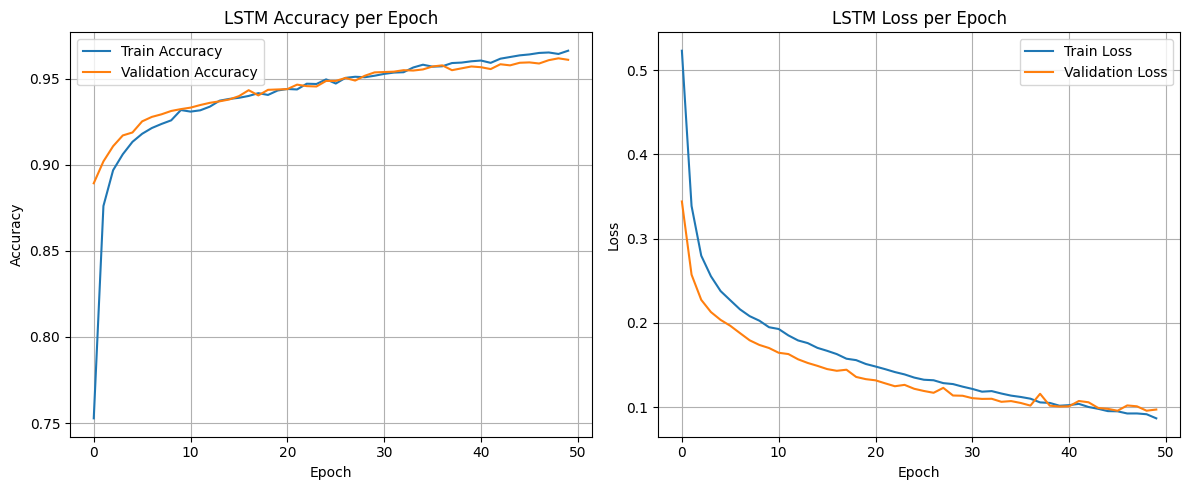


==== Summary for LSTM (over 5 runs) ====
Accuracy: 0.9597 ± 0.0032
Precision: 0.9696 ± 0.0053
Recall: 0.9492 ± 0.0042
F1: 0.9593 ± 0.0032
Auc: 0.9934 ± 0.0011


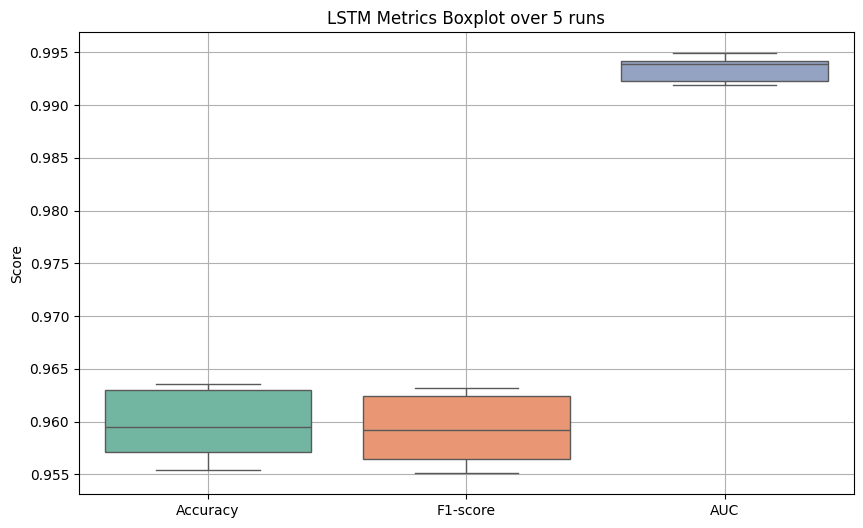


==== Training model: GRU ====
 Run 1/5
Epoch 1/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6983 - loss: 0.5783 - val_accuracy: 0.8930 - val_loss: 0.2840
Epoch 2/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8883 - loss: 0.2977 - val_accuracy: 0.9048 - val_loss: 0.2341
Epoch 3/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9009 - loss: 0.2590 - val_accuracy: 0.9106 - val_loss: 0.2184
Epoch 4/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9123 - loss: 0.2348 - val_accuracy: 0.9197 - val_loss: 0.2090
Epoch 5/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9179 - loss: 0.2241 - val_accuracy: 0.9203 - val_loss: 0.1970
Epoch 6/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9204 - loss: 0.2098 - val_accuracy: 0.9225 - val_loss: 0.1926
Epoch 7/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9229 - loss: 0.2008 - val_accuracy: 0.9259 - val_loss: 0.1842
Epoch 8/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 

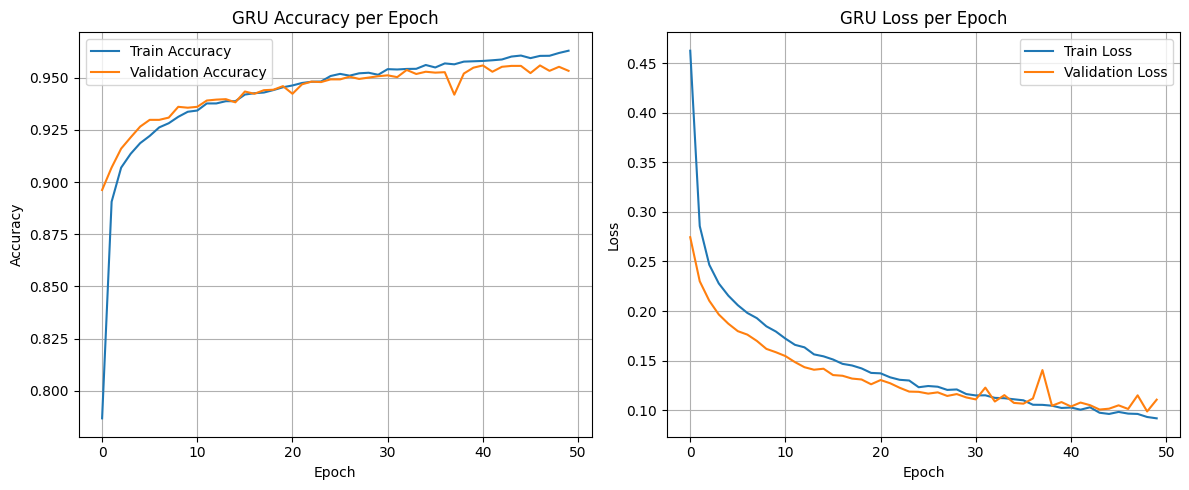


==== Summary for GRU (over 5 runs) ====
Accuracy: 0.9563 ± 0.0033
Precision: 0.9737 ± 0.0052
Recall: 0.9380 ± 0.0057
F1: 0.9555 ± 0.0034
Auc: 0.9930 ± 0.0012


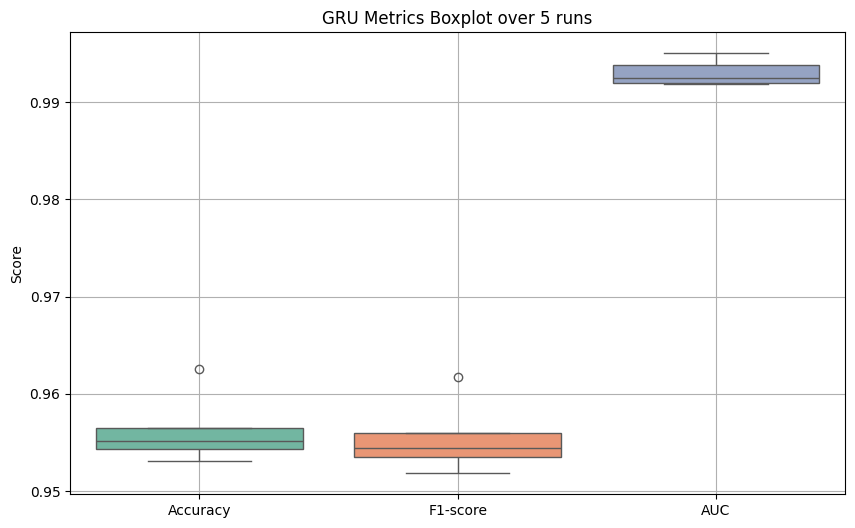


==== Training model: LSTM_GRU ====
 Run 1/5
Epoch 1/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.5767 - loss: 0.6746 - val_accuracy: 0.8691 - val_loss: 0.4543
Epoch 2/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8574 - loss: 0.4108 - val_accuracy: 0.9029 - val_loss: 0.2535
Epoch 3/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8921 - loss: 0.2877 - val_accuracy: 0.9126 - val_loss: 0.2262
Epoch 4/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9075 - loss: 0.2560 - val_accuracy: 0.9175 - val_loss: 0.2151
Epoch 5/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9107 - loss: 0.2389 - val_accuracy: 0.9216 - val_loss: 0.2075
Epoch 6/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9193 - loss: 0.2275 - val_accuracy: 0.9210 - val_loss: 0.2028
Epoch 7/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9215 - loss: 0.2137 - val_accuracy: 0.9274 - val_loss: 0.1942
Epoch 8/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - acc

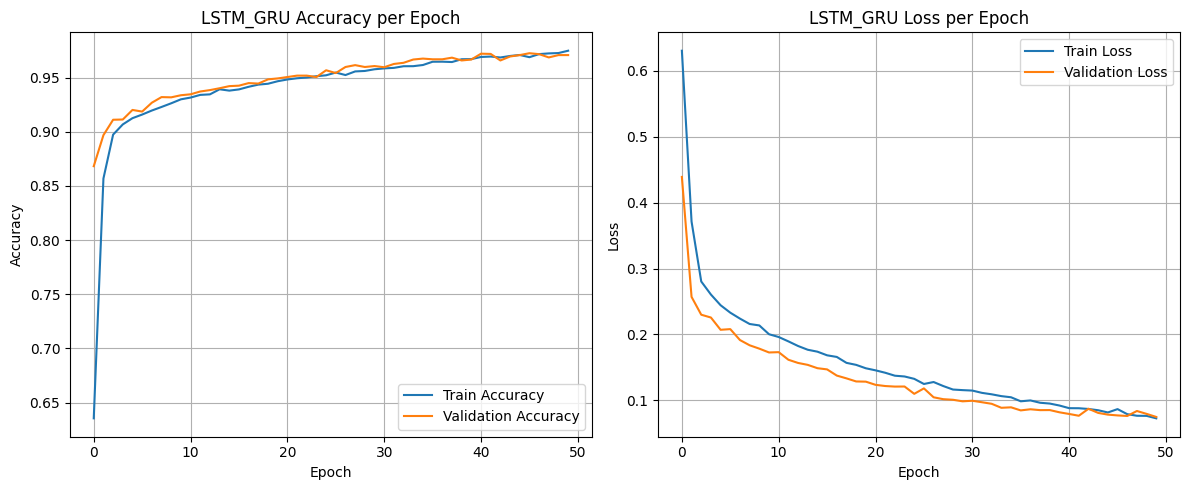


==== Summary for LSTM_GRU (over 5 runs) ====
Accuracy: 0.9700 ± 0.0037
Precision: 0.9755 ± 0.0046
Recall: 0.9642 ± 0.0080
F1: 0.9698 ± 0.0038
Auc: 0.9956 ± 0.0011


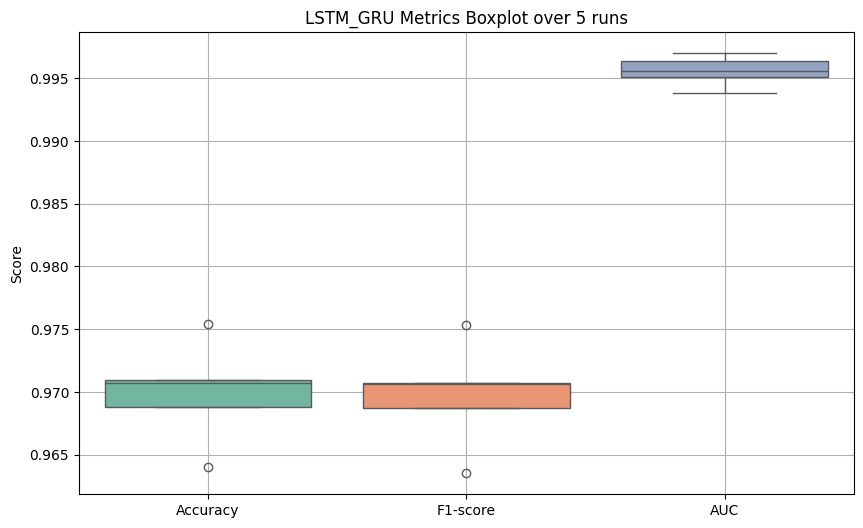


==== Training model: SimpleRNN ====
 Run 1/5
Epoch 1/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6293 - loss: 0.6332 - val_accuracy: 0.8585 - val_loss: 0.3435
Epoch 2/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8409 - loss: 0.3718 - val_accuracy: 0.8904 - val_loss: 0.2692
Epoch 3/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8786 - loss: 0.3083 - val_accuracy: 0.9007 - val_loss: 0.2409
Epoch 4/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8900 - loss: 0.2763 - val_accuracy: 0.9042 - val_loss: 0.2347
Epoch 5/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8969 - loss: 0.2576 - val_accuracy: 0.9121 - val_loss: 0.2172
Epoch 6/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9069 - loss: 0.2406 - val_accuracy: 0.9169 - val_loss: 0.2096
Epoch 7/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9133 - loss: 0.2328 - val_accuracy: 0.9171 - val_loss: 0.2048
Epoch 8/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accu

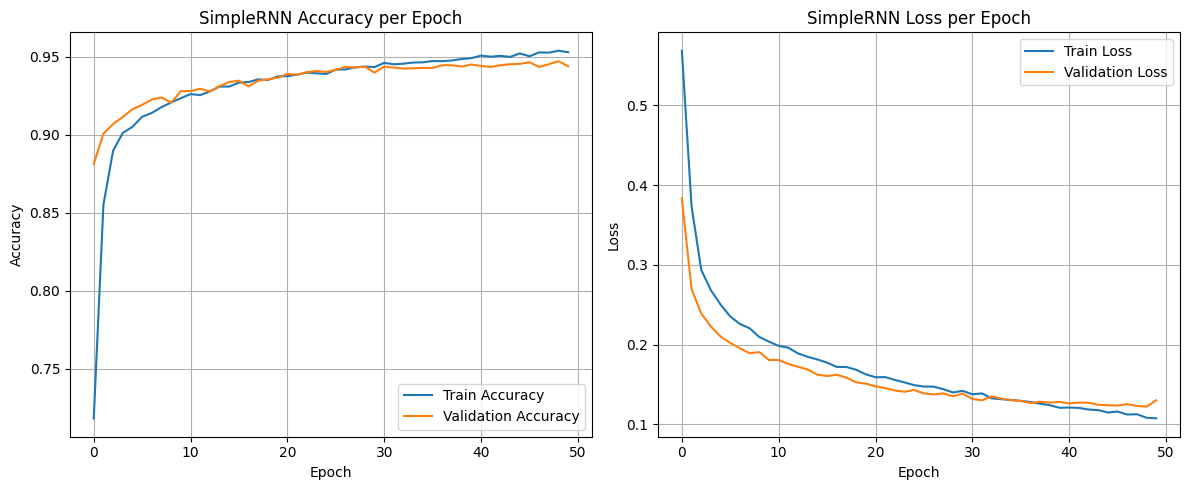


==== Summary for SimpleRNN (over 5 runs) ====
Accuracy: 0.9459 ± 0.0027
Precision: 0.9565 ± 0.0053
Recall: 0.9343 ± 0.0051
F1: 0.9452 ± 0.0027
Auc: 0.9885 ± 0.0018


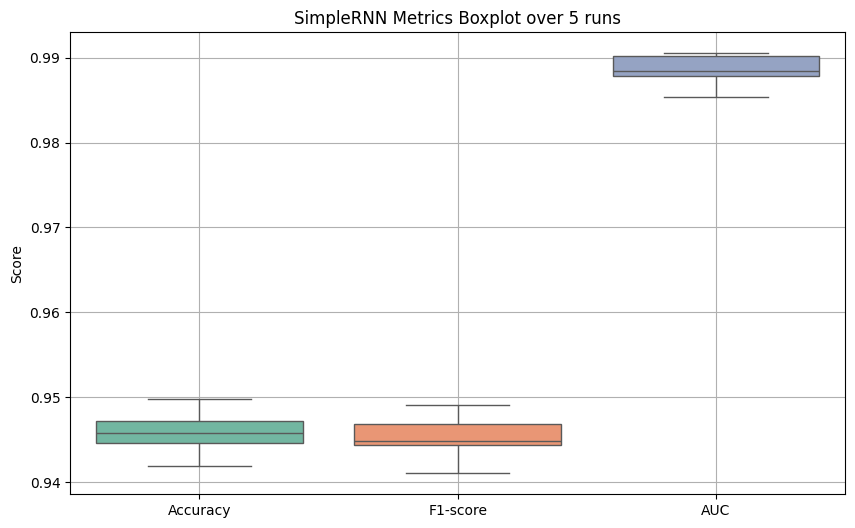


==== Training model: Dense ====
 Run 1/5
Epoch 1/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6341 - loss: 0.6233 - val_accuracy: 0.8613 - val_loss: 0.3486
Epoch 2/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8328 - loss: 0.3919 - val_accuracy: 0.8891 - val_loss: 0.2741
Epoch 3/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8759 - loss: 0.3135 - val_accuracy: 0.8964 - val_loss: 0.2495
Epoch 4/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8909 - loss: 0.2752 - val_accuracy: 0.9031 - val_loss: 0.2329
Epoch 5/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8987 - loss: 0.2565 - val_accuracy: 0.8914 - val_loss: 0.2411
Epoch 6/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9079 - loss: 0.2370 - val_accuracy: 0.9044 - val_loss: 0.2186
Epoch 7/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9090 - loss: 0.2315 - val_accuracy: 0.9121 - val_loss: 0.2120
Epoch 8/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy

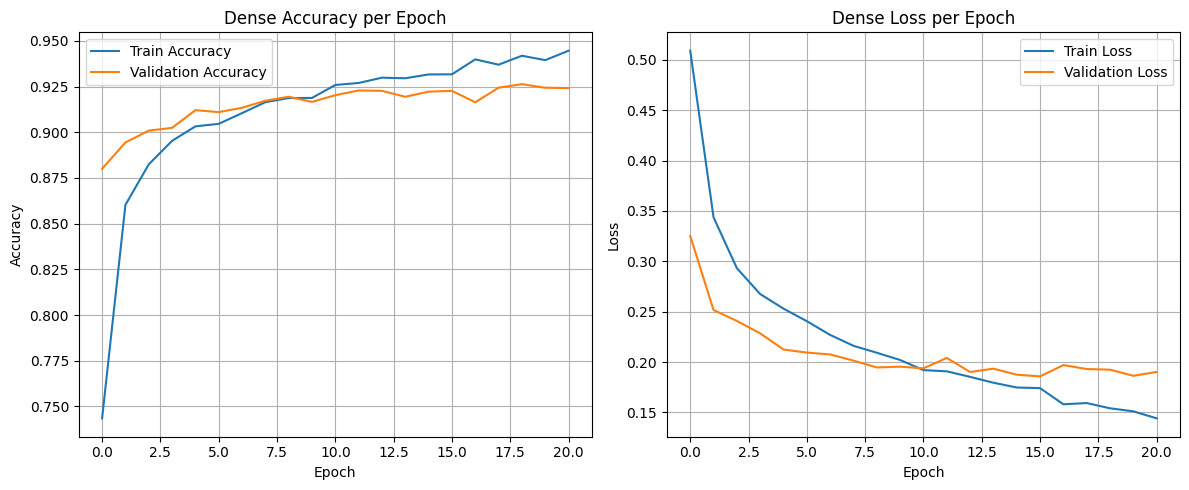


==== Summary for Dense (over 5 runs) ====
Accuracy: 0.9250 ± 0.0037
Precision: 0.9409 ± 0.0049
Recall: 0.9069 ± 0.0049
F1: 0.9236 ± 0.0038
Auc: 0.9780 ± 0.0016


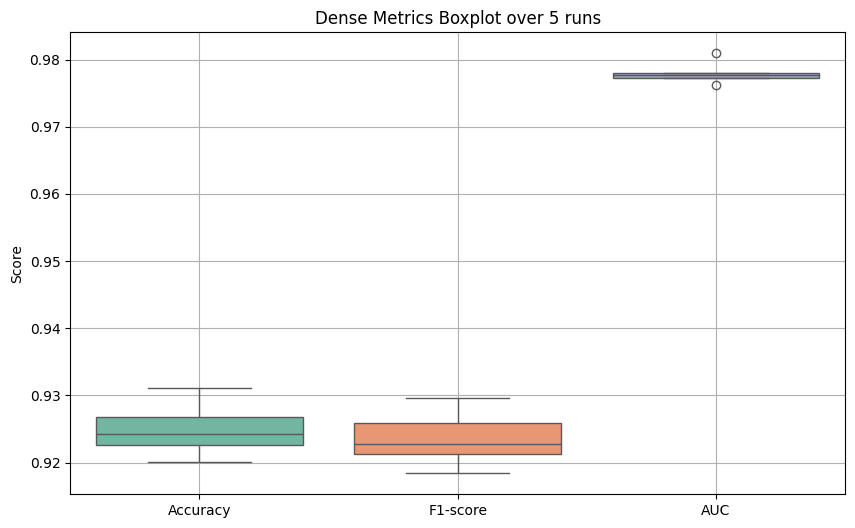


All run results saved to: /content/drive/MyDrive/AVA/results_all_models_maxvit_tiny_tf_224.csv


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, GRU, SimpleRNN, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, auc
)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import gc
from tensorflow.keras import backend as K

os.environ["CUDA_VISIBLE_DEVICES"] = ""

# --- Data loading and preprocessing ---
def prepare_data(normal_path, anomaly_path):
    X_normal = np.load(normal_path, allow_pickle=True)
    if X_normal.ndim >= 4:
        X_normal = X_normal.mean(axis=(2, 3))
    X_anomaly = np.load(anomaly_path, allow_pickle=True)
    if X_anomaly.ndim >= 4:
        X_anomaly = X_anomaly.mean(axis=(2, 3))
    X = np.concatenate([X_normal, X_anomaly])
    y = np.concatenate([np.zeros(len(X_normal)), np.ones(len(X_anomaly))])
    X = X.astype(np.float32)
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    X, y = shuffle(X, y, random_state=42)
    return X, y

def create_sequences(X, y, seq_len=5):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len + 1):
        X_seq.append(X[i:i + seq_len])
        y_seq.append(y[i + seq_len - 1])
    return np.array(X_seq), np.array(y_seq)

# --- Model builders with 32 and 16 units ---
def build_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(32, activation='tanh', recurrent_activation='sigmoid', unroll=True)(inputs)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_gru_model(input_shape):
    inputs = Input(shape=input_shape)
    x = GRU(32)(inputs)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_lstm_gru_model(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(32, return_sequences=True, unroll=True)(inputs)
    x = Dropout(0.3)(x)
    x = GRU(32)(x)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_simple_rnn_model(input_shape):
    inputs = Input(shape=input_shape)
    x = SimpleRNN(32)(inputs)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_dense_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Flatten()(inputs)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# --- Main execution ---
def main():
    feature_model_name = 'maxvit_tiny_tf_224'  # Change if needed
    seq_len = 10
    save_dir = '/content/drive/MyDrive/AVA'  # Change to your data path
    normal_path = f"{save_dir}/normal_features_{feature_model_name}.npy"
    anomaly_path = f"{save_dir}/anomaly_features_{feature_model_name}.npy"

    X, y = prepare_data(normal_path, anomaly_path)
    X_seq, y_seq = create_sequences(X, y, seq_len=seq_len)

    model_builders = {
        "LSTM": build_lstm_model,
        "GRU": build_gru_model,
        "LSTM_GRU": build_lstm_gru_model,
        "SimpleRNN": build_simple_rnn_model,
        "Dense": build_dense_model
    }

    num_runs = 5
    all_results = []

    for model_name, builder in model_builders.items():
        print(f"\n==== Training model: {model_name} ====")

        metrics_list = {
            "accuracy": [],
            "precision": [],
            "recall": [],
            "f1": [],
            "auc": []
        }

        histories = []

        for run in range(num_runs):
            print(f" Run {run+1}/{num_runs}")

            X_train, X_test, y_train, y_test = train_test_split(
                X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=run
            )

            model = builder(X_train.shape[1:])
            es = EarlyStopping(patience=5, restore_best_weights=True, verbose=0)
            history = model.fit(
                X_train, y_train,
                validation_data=(X_test, y_test),
                epochs=50,
                batch_size=32,
                callbacks=[es],
                verbose=1
            )
            histories.append(history)

            y_prob = model.predict(X_test).ravel()
            y_pred = (y_prob > 0.5).astype(int)

            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, zero_division=0)
            rec = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            auc_score = roc_auc_score(y_test, y_prob)

            # Store metrics
            metrics_list["accuracy"].append(acc)
            metrics_list["precision"].append(prec)
            metrics_list["recall"].append(rec)
            metrics_list["f1"].append(f1)
            metrics_list["auc"].append(auc_score)

            all_results.append({
                "Model": model_name,
                "Run": run + 1,
                "Accuracy": acc,
                "Precision": prec,
                "Recall": rec,
                "F1": f1,
                "AUC": auc_score
            })

            # Clear to save memory
            K.clear_session()
            del model
            gc.collect()

        # Plot training curves for last run
        last_history = histories[-1]
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(last_history.history['accuracy'], label='Train Accuracy')
        plt.plot(last_history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'{model_name} Accuracy per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.subplot(1,2,2)
        plt.plot(last_history.history['loss'], label='Train Loss')
        plt.plot(last_history.history['val_loss'], label='Validation Loss')
        plt.title(f'{model_name} Loss per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Print mean ± std summary for all runs
        print(f"\n==== Summary for {model_name} (over {num_runs} runs) ====")
        for metric in metrics_list:
            mean_val = np.mean(metrics_list[metric])
            std_val = np.std(metrics_list[metric])
            print(f"{metric.capitalize()}: {mean_val:.4f} ± {std_val:.4f}")

        # Plot boxplots of the 5 runs for metrics
        plt.figure(figsize=(10,6))
        sns.boxplot(data=[metrics_list["accuracy"], metrics_list["f1"], metrics_list["auc"]],
                    palette="Set2")
        plt.xticks([0,1,2], ['Accuracy', 'F1-score', 'AUC'])
        plt.title(f'{model_name} Metrics Boxplot over {num_runs} runs')
        plt.ylabel('Score')
        plt.grid(True)
        plt.show()

    # Save all results to CSV
    df = pd.DataFrame(all_results)
    csv_save_path = os.path.join(save_dir, f"results_all_models_{feature_model_name}.csv")
    df.to_csv(csv_save_path, index=False)
    print(f"\nAll run results saved to: {csv_save_path}")

if __name__ == "__main__":
    main()



==== Training model: LSTM ====
 Run 1/5
Epoch 1/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7053 - loss: 0.5445 - val_accuracy: 0.9031 - val_loss: 0.2671
Epoch 2/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8978 - loss: 0.2924 - val_accuracy: 0.9147 - val_loss: 0.2258
Epoch 3/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9092 - loss: 0.2476 - val_accuracy: 0.9188 - val_loss: 0.2032
Epoch 4/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9185 - loss: 0.2228 - val_accuracy: 0.9253 - val_loss: 0.1908
Epoch 5/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9279 - loss: 0.1986 - val_accuracy: 0.9309 - val_loss: 0.1741
Epoch 6/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9280 - loss: 0.1953 - val_accuracy: 0.9354 - val_loss: 0.1634
Epoch 7/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9344 - loss: 0.1812 - val_accuracy: 0.9345 - val_loss: 0.1620
Epoch 8/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy:

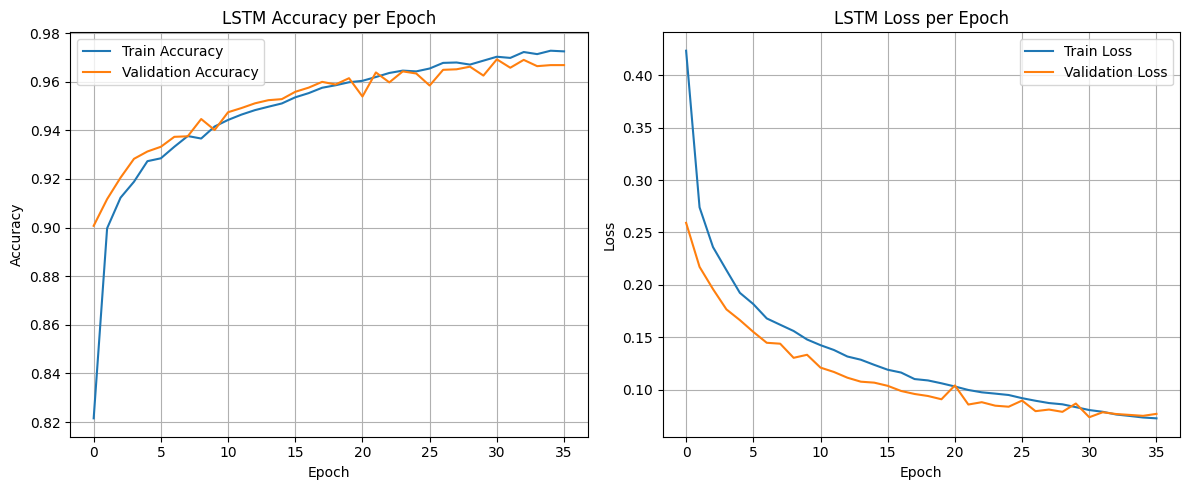


==== Summary for LSTM (over 5 runs) ====
Accuracy: 0.9689 ± 0.0055
Precision: 0.9775 ± 0.0033
Recall: 0.9599 ± 0.0105
F1: 0.9686 ± 0.0057
Auc: 0.9960 ± 0.0013


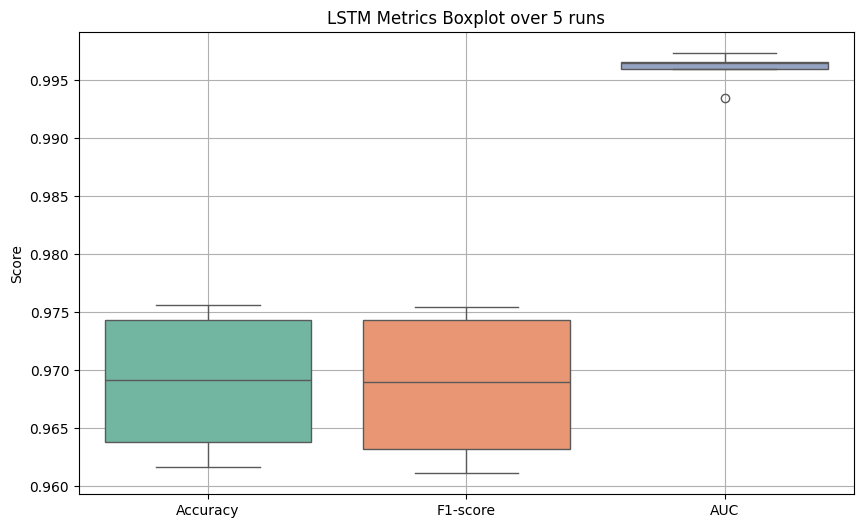


==== Training model: GRU ====
 Run 1/5
Epoch 1/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6948 - loss: 0.5565 - val_accuracy: 0.9065 - val_loss: 0.2562
Epoch 2/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8942 - loss: 0.2873 - val_accuracy: 0.9128 - val_loss: 0.2185
Epoch 3/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9121 - loss: 0.2397 - val_accuracy: 0.9199 - val_loss: 0.1963
Epoch 4/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9144 - loss: 0.2187 - val_accuracy: 0.9272 - val_loss: 0.1790
Epoch 5/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9202 - loss: 0.2087 - val_accuracy: 0.9302 - val_loss: 0.1677
Epoch 6/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9287 - loss: 0.1799 - val_accuracy: 0.9315 - val_loss: 0.1573
Epoch 7/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9280 - loss: 0.1768 - val_accuracy: 0.9337 - val_loss: 0.1499
Epoch 8/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 

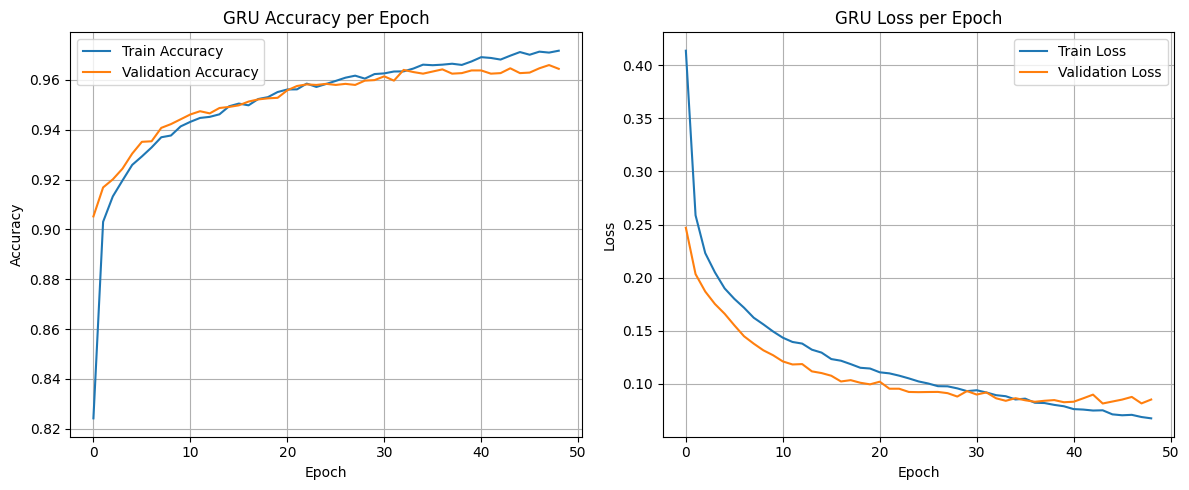


==== Summary for GRU (over 5 runs) ====
Accuracy: 0.9633 ± 0.0037
Precision: 0.9768 ± 0.0040
Recall: 0.9492 ± 0.0085
F1: 0.9627 ± 0.0039
Auc: 0.9951 ± 0.0011


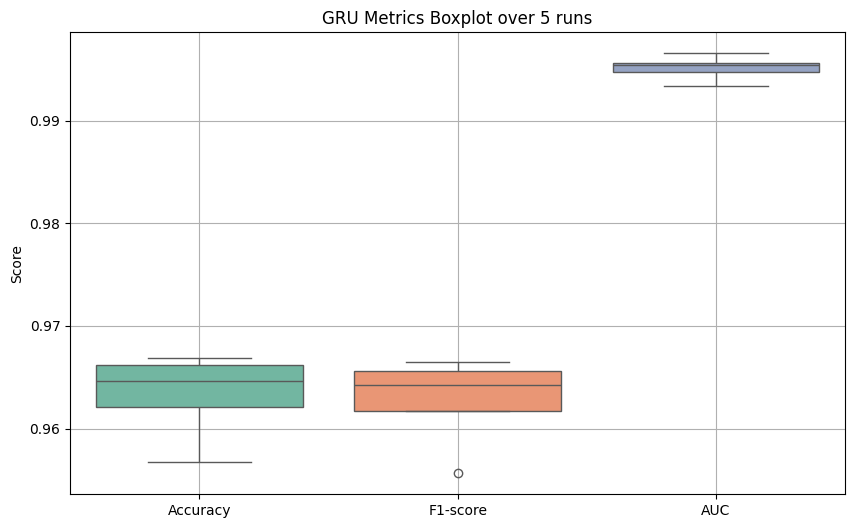


==== Training model: LSTM_GRU ====
 Run 1/5
Epoch 1/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.6356 - loss: 0.6246 - val_accuracy: 0.9061 - val_loss: 0.2860
Epoch 2/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8892 - loss: 0.3200 - val_accuracy: 0.9188 - val_loss: 0.2137
Epoch 3/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9120 - loss: 0.2450 - val_accuracy: 0.9238 - val_loss: 0.1920
Epoch 4/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9222 - loss: 0.2139 - val_accuracy: 0.9300 - val_loss: 0.1740
Epoch 5/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9284 - loss: 0.2013 - val_accuracy: 0.9350 - val_loss: 0.1637
Epoch 6/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9287 - loss: 0.1910 - val_accuracy: 0.9378 - val_loss: 0.1557
Epoch 7/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9320 - loss: 0.1832 - val_accuracy: 0.9425 - val_loss: 0.1474
Epoch 8/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - acc

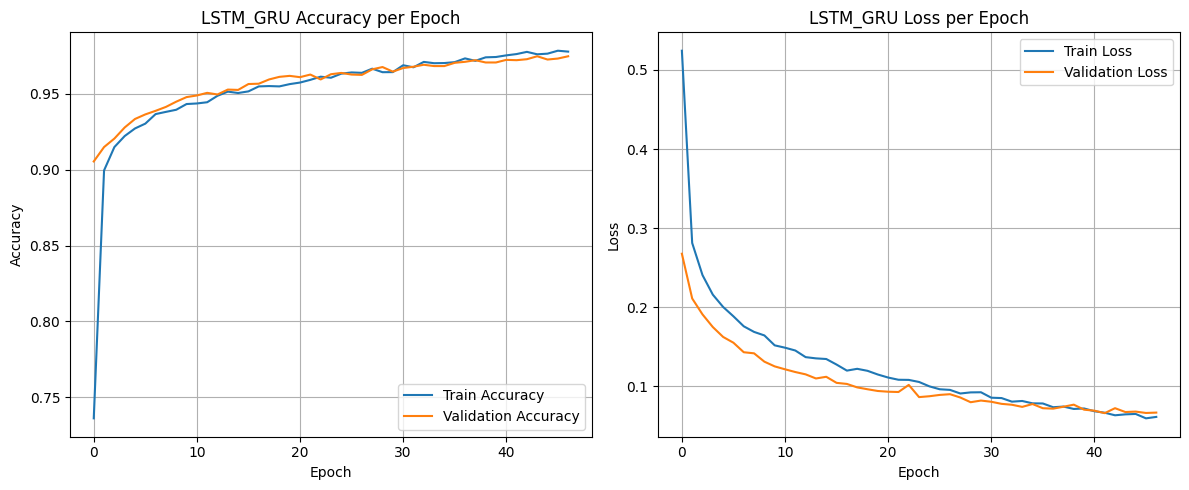


==== Summary for LSTM_GRU (over 5 runs) ====
Accuracy: 0.9754 ± 0.0032
Precision: 0.9815 ± 0.0048
Recall: 0.9690 ± 0.0077
F1: 0.9752 ± 0.0033
Auc: 0.9970 ± 0.0009


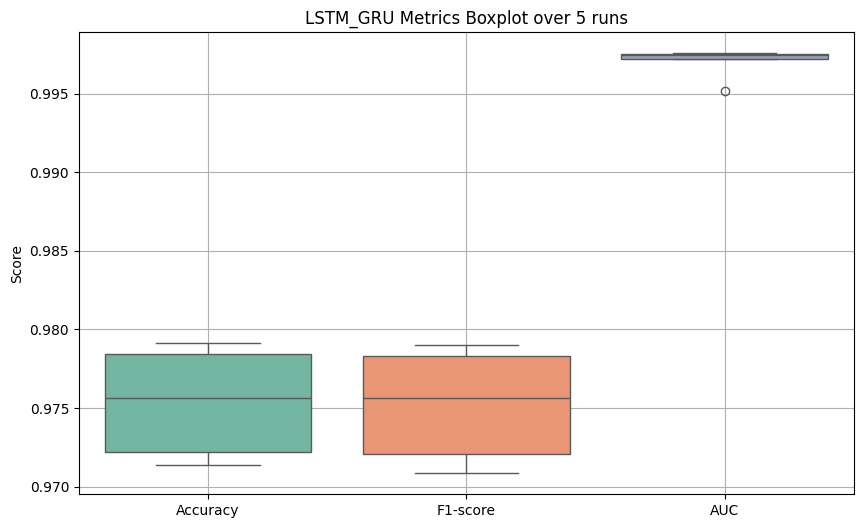


==== Training model: SimpleRNN ====
 Run 1/5
Epoch 1/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6199 - loss: 0.6078 - val_accuracy: 0.8884 - val_loss: 0.2798
Epoch 2/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8670 - loss: 0.3146 - val_accuracy: 0.9104 - val_loss: 0.2225
Epoch 3/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9010 - loss: 0.2518 - val_accuracy: 0.9123 - val_loss: 0.2006
Epoch 4/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9068 - loss: 0.2346 - val_accuracy: 0.9190 - val_loss: 0.1902
Epoch 5/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9087 - loss: 0.2217 - val_accuracy: 0.9220 - val_loss: 0.1790
Epoch 6/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9159 - loss: 0.2034 - val_accuracy: 0.9238 - val_loss: 0.1700
Epoch 7/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9273 - loss: 0.1870 - val_accuracy: 0.9291 - val_loss: 0.1606
Epoch 8/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accu

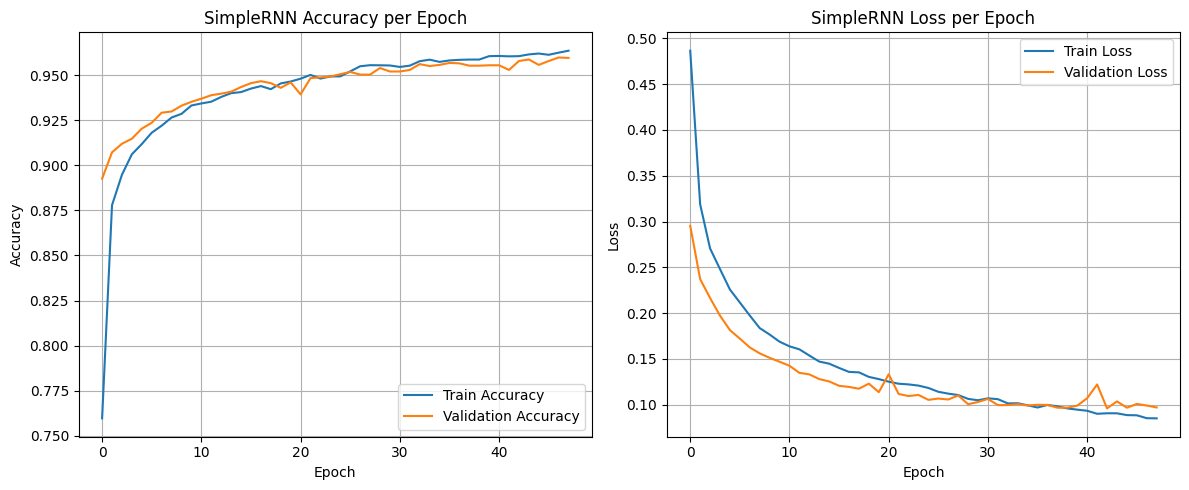


==== Summary for SimpleRNN (over 5 runs) ====
Accuracy: 0.9568 ± 0.0021
Precision: 0.9702 ± 0.0068
Recall: 0.9427 ± 0.0075
F1: 0.9562 ± 0.0022
Auc: 0.9933 ± 0.0008


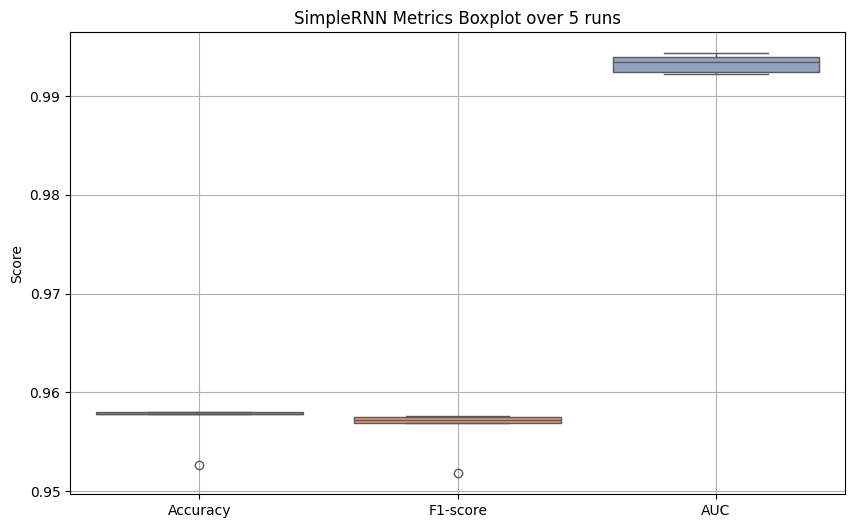


==== Training model: Dense ====
 Run 1/5
Epoch 1/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6898 - loss: 0.5577 - val_accuracy: 0.8893 - val_loss: 0.2925
Epoch 2/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8597 - loss: 0.3338 - val_accuracy: 0.9005 - val_loss: 0.2508
Epoch 3/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8817 - loss: 0.2909 - val_accuracy: 0.9061 - val_loss: 0.2236
Epoch 4/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8976 - loss: 0.2614 - val_accuracy: 0.9117 - val_loss: 0.2136
Epoch 5/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9064 - loss: 0.2398 - val_accuracy: 0.9087 - val_loss: 0.2105
Epoch 6/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9137 - loss: 0.2253 - val_accuracy: 0.9169 - val_loss: 0.1993
Epoch 7/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9153 - loss: 0.2126 - val_accuracy: 0.9151 - val_loss: 0.1969
Epoch 8/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy

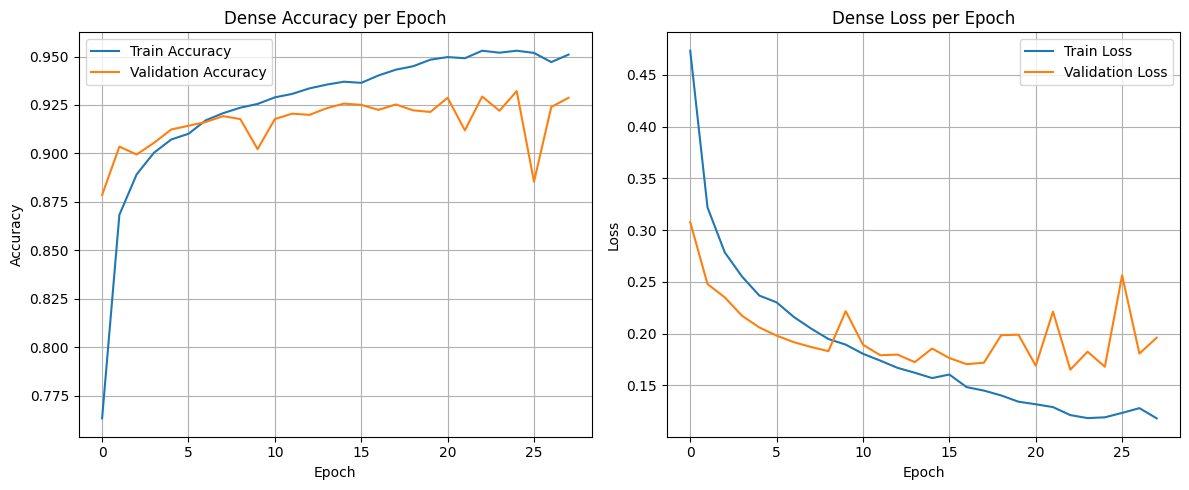


==== Summary for Dense (over 5 runs) ====
Accuracy: 0.9250 ± 0.0041
Precision: 0.9403 ± 0.0107
Recall: 0.9079 ± 0.0112
F1: 0.9237 ± 0.0042
Auc: 0.9814 ± 0.0022


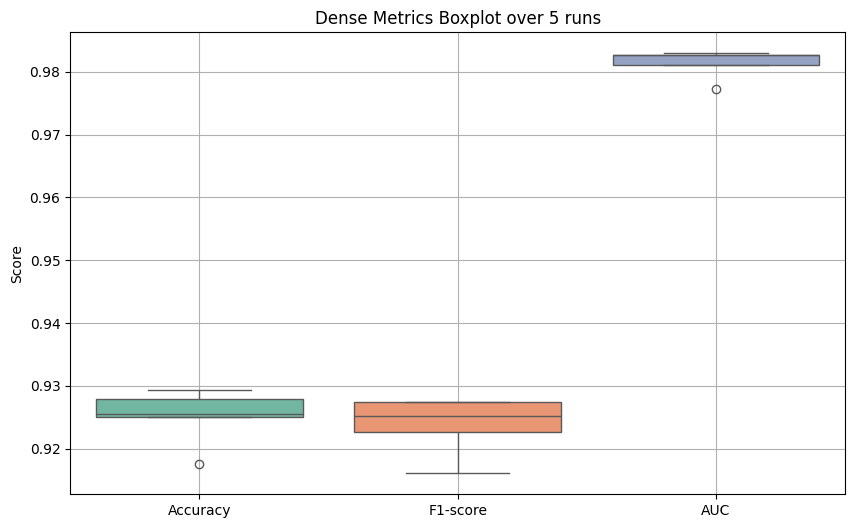


All run results saved to: /content/drive/MyDrive/AVA/results_all_models_coatnet_0_rw_224.csv


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, GRU, SimpleRNN, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, auc
)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import gc
from tensorflow.keras import backend as K

os.environ["CUDA_VISIBLE_DEVICES"] = ""

# --- Data loading and preprocessing ---
def prepare_data(normal_path, anomaly_path):
    X_normal = np.load(normal_path, allow_pickle=True)
    if X_normal.ndim >= 4:
        X_normal = X_normal.mean(axis=(2, 3))
    X_anomaly = np.load(anomaly_path, allow_pickle=True)
    if X_anomaly.ndim >= 4:
        X_anomaly = X_anomaly.mean(axis=(2, 3))
    X = np.concatenate([X_normal, X_anomaly])
    y = np.concatenate([np.zeros(len(X_normal)), np.ones(len(X_anomaly))])
    X = X.astype(np.float32)
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    X, y = shuffle(X, y, random_state=42)
    return X, y

def create_sequences(X, y, seq_len=5):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len + 1):
        X_seq.append(X[i:i + seq_len])
        y_seq.append(y[i + seq_len - 1])
    return np.array(X_seq), np.array(y_seq)

# --- Model builders with 32 and 16 units ---
def build_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(32, activation='tanh', recurrent_activation='sigmoid', unroll=True)(inputs)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_gru_model(input_shape):
    inputs = Input(shape=input_shape)
    x = GRU(32)(inputs)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_lstm_gru_model(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(32, return_sequences=True, unroll=True)(inputs)
    x = Dropout(0.3)(x)
    x = GRU(32)(x)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_simple_rnn_model(input_shape):
    inputs = Input(shape=input_shape)
    x = SimpleRNN(32)(inputs)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_dense_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Flatten()(inputs)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# --- Main execution ---
def main():
    feature_model_name = 'coatnet_0_rw_224'  # Change if needed
    seq_len = 10
    save_dir = '/content/drive/MyDrive/AVA'  # Change to your data path
    normal_path = f"{save_dir}/normal_features_{feature_model_name}.npy"
    anomaly_path = f"{save_dir}/anomaly_features_{feature_model_name}.npy"

    X, y = prepare_data(normal_path, anomaly_path)
    X_seq, y_seq = create_sequences(X, y, seq_len=seq_len)

    model_builders = {
        "LSTM": build_lstm_model,
        "GRU": build_gru_model,
        "LSTM_GRU": build_lstm_gru_model,
        "SimpleRNN": build_simple_rnn_model,
        "Dense": build_dense_model
    }

    num_runs = 5
    all_results = []

    for model_name, builder in model_builders.items():
        print(f"\n==== Training model: {model_name} ====")

        metrics_list = {
            "accuracy": [],
            "precision": [],
            "recall": [],
            "f1": [],
            "auc": []
        }

        histories = []

        for run in range(num_runs):
            print(f" Run {run+1}/{num_runs}")

            X_train, X_test, y_train, y_test = train_test_split(
                X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=run
            )

            model = builder(X_train.shape[1:])
            es = EarlyStopping(patience=5, restore_best_weights=True, verbose=0)
            history = model.fit(
                X_train, y_train,
                validation_data=(X_test, y_test),
                epochs=50,
                batch_size=32,
                callbacks=[es],
                verbose=1
            )
            histories.append(history)

            y_prob = model.predict(X_test).ravel()
            y_pred = (y_prob > 0.5).astype(int)

            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, zero_division=0)
            rec = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            auc_score = roc_auc_score(y_test, y_prob)

            # Store metrics
            metrics_list["accuracy"].append(acc)
            metrics_list["precision"].append(prec)
            metrics_list["recall"].append(rec)
            metrics_list["f1"].append(f1)
            metrics_list["auc"].append(auc_score)

            all_results.append({
                "Model": model_name,
                "Run": run + 1,
                "Accuracy": acc,
                "Precision": prec,
                "Recall": rec,
                "F1": f1,
                "AUC": auc_score
            })

            # Clear to save memory
            K.clear_session()
            del model
            gc.collect()

        # Plot training curves for last run
        last_history = histories[-1]
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(last_history.history['accuracy'], label='Train Accuracy')
        plt.plot(last_history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'{model_name} Accuracy per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.subplot(1,2,2)
        plt.plot(last_history.history['loss'], label='Train Loss')
        plt.plot(last_history.history['val_loss'], label='Validation Loss')
        plt.title(f'{model_name} Loss per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Print mean ± std summary for all runs
        print(f"\n==== Summary for {model_name} (over {num_runs} runs) ====")
        for metric in metrics_list:
            mean_val = np.mean(metrics_list[metric])
            std_val = np.std(metrics_list[metric])
            print(f"{metric.capitalize()}: {mean_val:.4f} ± {std_val:.4f}")

        # Plot boxplots of the 5 runs for metrics
        plt.figure(figsize=(10,6))
        sns.boxplot(data=[metrics_list["accuracy"], metrics_list["f1"], metrics_list["auc"]],
                    palette="Set2")
        plt.xticks([0,1,2], ['Accuracy', 'F1-score', 'AUC'])
        plt.title(f'{model_name} Metrics Boxplot over {num_runs} runs')
        plt.ylabel('Score')
        plt.grid(True)
        plt.show()

    # Save all results to CSV
    df = pd.DataFrame(all_results)
    csv_save_path = os.path.join(save_dir, f"results_all_models_{feature_model_name}.csv")
    df.to_csv(csv_save_path, index=False)
    print(f"\nAll run results saved to: {csv_save_path}")

if __name__ == "__main__":
    main()
